# Important Frequencies Selection

## Import Libraries and seed
Import the necessary libraries for data processing, model building, training, and evaluation. Adding a seed ensures reproducibility by making sure that the random number generation is consistent across different runs.

In [ ]:
import os
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import joblib
import matplotlib.pyplot as plt
import graphviz 
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import export_graphviz
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier

from scipy.stats import zscore

# import wandb

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    return seed

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Set seed for reproducibility
seed = set_seed(42)


Using device: cpu


In [66]:
def load_data_from_directory(input_path):
    data_frames = []
    for file in os.listdir(input_path):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(input_path, file), delimiter=';', header=0)
            data_frames.append(df)
    data = pd.concat(data_frames, ignore_index=True)

    return data

## Preprocessing Data
Define a function to preprocess the data. This includes encoding categorical labels and standardizing the features.

In [67]:
def calculate_averages_and_dispersion(df, data_percentage):

    results = []
    for (sample, freq), group in df.groupby(['Sample', 'Frequency (GHz)']):
        window_size = max(1, int(len(group) * data_percentage / 100))
        # print(f"Processing sample: {sample}, frequency: {freq} with window size: {window_size}")
        for start in range(0, len(group), window_size):
            window_data = group.iloc[start:start + window_size]
            mean_values = window_data[['LG (mV)', 'HG (mV)']].mean()
            std_deviation_values = window_data[['LG (mV)', 'HG (mV)']].std()
            results.append({
                'Frequency (GHz)': freq,
                'LG (mV) mean': mean_values['LG (mV)'],
                'HG (mV) mean': mean_values['HG (mV)'],
                'LG (mV) std deviation': std_deviation_values['LG (mV)'],
                'HG (mV) std deviation': std_deviation_values['HG (mV)'],
                # 'Thickness (mm)': window_data['Thickness (mm)'].iloc[0], ## COMMENT
                'Sample': sample,
            })
    results_df = pd.DataFrame(results)
    # results_df.to_csv(output_file, sep=';', index=False)
    # print(f"Processed {input_file} and saved to {output_file}")
    # print(results_df)
    return results_df

## Pivoting Frequency values to columns

In [68]:
def freq_as_variable(df, data_percentage):
    '''Modify df to have Frequency values (100,110,120 and so on) as input variables in the columns'''

    # Remove Thickness column
    if 'Thickness (mm)' in df.columns:
        df = df.drop(columns=['Thickness (mm)'])

    if data_percentage > 0:
        # 1s window_size 100/27s = 3.7% of the data is used for each window
        df_window = calculate_averages_and_dispersion(df, data_percentage) 

        # Add a unique identifier column to avoid duplicate entries in the index
        df_window['unique_id'] = df_window.groupby(['Sample', 'Frequency (GHz)']).cumcount()

        # Pivot the DataFrame to wide format
        df_pivot = df_window.pivot(index=['Sample', 'unique_id'], columns='Frequency (GHz)')

        # Flatten the MultiIndex columns - Ordered by Frequency + (HG mean, HG std deviation, LG mean, LG std deviation)
        df_pivot.columns = [' '.join([str(col[1]), str(col[0])]) for col in df_pivot.columns]

        # Drop columns with all NaN values
        df_pivot = df_pivot.dropna(axis=1, how='all')

        # Reset index to make 'Sample' and 'unique_id' columns again
        df_pivot = df_pivot.reset_index()

        # Remove 'unique_id' column
        df_pivot = df_pivot.drop(columns=['unique_id'])
    else:
        # If data_percentage is 0, do not calculate mean and std deviation, use the original data
        df['unique_id'] = df.groupby(['Sample', 'Frequency (GHz)']).cumcount()
        df_pivot = df.pivot(index=['Sample', 'unique_id'], columns='Frequency (GHz)')
        df_pivot.columns = [' '.join([str(col[1]), str(col[0])]) for col in df_pivot.columns]
        df_pivot = df_pivot.dropna(axis=1, how='all')
        df_pivot = df_pivot.reset_index()
        df_pivot = df_pivot.drop(columns=['unique_id'])

    # Optional - Sort the columns if needed
    df_pivot = df_pivot.reindex(sorted(df_pivot.columns), axis=1)

    return df_pivot

In [69]:
# Load the data from the directory
input_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_5_plastics/processed/'
# input_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test'
# input_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_4_plastics/processed/'

df = load_data_from_directory(input_path)

df = pd.concat([df[['Frequency (GHz)', 'LG (mV)', 'HG (mV)']], df[['Sample']]], axis=1)

df_ori = df.copy()

# Find if value samples have '_' in the name and remove everything after '_' 
# df['Sample'] = df['Sample'].str.split('_').str[0]
df['Sample'] = df['Sample'].str[0]

df.head(10)


,Frequency (GHz),LG (mV),HG (mV),Sample
0,100.0,0.366256,24.172872,A
1,100.0,-0.244170,37.846416,A
2,100.0,-1.831278,42.241484,A
3,100.0,1.220852,36.015138,A
4,100.0,0.610426,41.997313,A
5,100.0,-0.244170,24.172872,A
6,100.0,1.953363,26.370406,A
7,100.0,0.732511,19.045293,A
8,100.0,0.000000,32.840922,A
9,100.0,-0.122085,22.707850,A


## Balance Dataset

C:\Users\Danim\AppData\Local\Temp\ipykernel_36136\3669193858.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


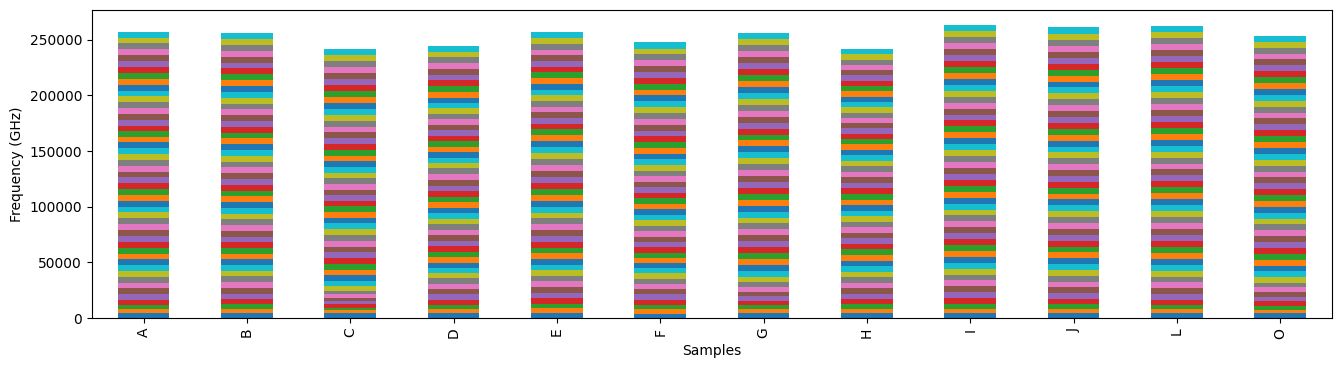

Mean value: 5073


C:\Users\Danim\AppData\Local\Temp\ipykernel_36136\3669193858.py:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


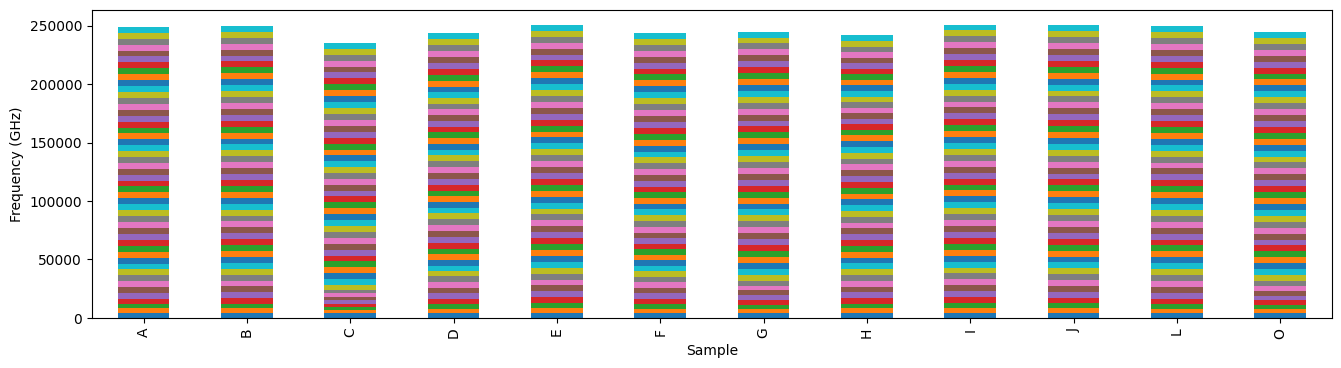

In [70]:
# Number of samples per frequency and Sample
bx = df.groupby(['Sample', 'Frequency (GHz)']).size().unstack().plot.bar(figsize=(16, 4), stacked=True)
bx.set_xlabel('Samples')
bx.set_ylabel('Frequency (GHz)')
plt.tight_layout()
#no legend
bx.get_legend().remove()
plt.show()

# Balance the data by taking the mode of samples per frequency
mean= int(df.groupby(['Sample', 'Frequency (GHz)']).size().mean())
print(f'Mean value: {mean}')


# Function to reduce samples to the mean value
def reduce_to_mean(df, sample, frequency, mean):
    # Filter the DataFrame for the specific sample and frequency
    freq_df = df[(df['Sample'] == sample) & (df['Frequency (GHz)'] == frequency)]
    # If the number of samples is greater than the mean, sample down to the mean
    if len(freq_df) > mean:
        return freq_df.sample(n=mean, random_state=42)
    return freq_df

# Apply the function to reduce samples for each combination of Sample and Frequency (GHz)
balanced_data = []
for (sample, frequency), group in df.groupby(['Sample', 'Frequency (GHz)']):
    balanced_data.append(reduce_to_mean(df, sample, frequency, mean))

# Combine the balanced samples into a single DataFrame
df_balanced = pd.concat(balanced_data)

bx = df_balanced.groupby(['Sample', 'Frequency (GHz)']).size().unstack().plot.bar(figsize=(16, 4), stacked=True)
bx.set_ylabel('Frequency (GHz)')
plt.tight_layout()
# legend small
bx.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
#remove legend
bx.get_legend().remove()
plt.show()

## Data Feature Transformation Visualization

In [1]:
# Group by 'Sample' and 'Frequency (GHz)' and calculate the mean and standard deviation
mean_std_df = df_ori.groupby(['Sample', 'Frequency (GHz)']).agg(
    LG_mean=('LG (mV)', 'mean'),
    LG_std=('LG (mV)', 'std'),
    HG_mean=('HG (mV)', 'mean'),
    HG_std=('HG (mV)', 'std')
).reset_index()

print(mean_std_df)

# Substract the HG mean value of the previous frequency 
# Create a new DataFrame to store the differences
diff_df = mean_std_df.copy()

# Calculate the difference in HG and LGmean values between consecutive frequencies for each sample
diff_df['HG_mean_diff'] = diff_df.groupby('Sample')['HG_mean'].diff()
diff_df['LG_mean_diff'] = diff_df.groupby('Sample')['LG_mean'].diff()

# Rows where the difference could not be calculated are equal to 0
diff_df['HG_mean_diff'] = diff_df['HG_mean_diff'].fillna(0)
diff_df['LG_mean_diff'] = diff_df['LG_mean_diff'].fillna(0)

print(diff_df)


# Plot the difference in HG mean values for each sample
unique_samples = diff_df['Sample'].unique()

fig, axes = plt.subplots((len(unique_samples) + 3) // 4, 4, figsize=(20, 5 * ((len(unique_samples) + 3) // 4)), sharex=True)

for i, sample in enumerate(unique_samples):
    row, col = divmod(i, 4)
    sample_df = diff_df[diff_df['Sample'] == sample]
    sample_df.plot(x='Frequency (GHz)', y='HG_mean_diff', ax=axes[row, col], label=sample)
    axes[row, col].set_ylabel('HG Mean Difference')
    axes[row, col].legend(title='Sample')
    axes[row, col].xaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Ensure integer ticks
    axes[row, col].xaxis.set_major_locator(plt.MultipleLocator(5))  # Add more ticks
    axes[row, col].grid(True, alpha=0.5)  # Add grid with transparency

for j in range(i + 1, len(axes.flatten())):
    fig.delaxes(axes.flatten()[j])

axes[-1, 0].set_xlabel('Frequency (GHz)')
plt.tight_layout()
plt.show()


# Plot the difference in HG mean values for each group of samples starting with the same letter
unique_sample_groups = sorted(set(sample[0] for sample in unique_samples))

# Calculate the number of rows needed
n_rows = len(unique_sample_groups)

fig, axes = plt.subplots(n_rows, 1, figsize=(20, 5 * n_rows), sharex=True)

# Ensure axes is always a 1D array
if n_rows == 1:
    axes = np.array([axes])

for i, group in enumerate(unique_sample_groups):
    group_samples = [sample for sample in unique_samples if sample.startswith(group)]
    for sample in group_samples:
        sample_df = diff_df[diff_df['Sample'] == sample]
        sample_df.plot(x='Frequency (GHz)', y='HG_mean_diff', ax=axes[i], label=sample)
    axes[i].set_ylabel('HG Mean Difference')
    axes[i].legend(title='Sample')
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Ensure integer ticks
    axes[i].xaxis.set_major_locator(plt.MultipleLocator(5))  # Add more ticks
    axes[i].grid(True, alpha=0.5)  # Add grid with transparency

axes[-1].set_xlabel('Frequency (GHz)')
plt.tight_layout()
plt.show()


NameError: name 'df_ori' is not defined

## Sample a test set

In [71]:
df_train = df_balanced.copy()

test_percentage = 0.25

# # Shuffle the data
# df_train = df_train.sample(frac=1, random_state=42)

train_set, test_set = train_test_split(df_train, test_size=test_percentage, random_state=42) 

# stratify=df['Sample'] to keep the same proportion of samples in the train and test set

train_set.head()




,Frequency (GHz),LG (mV),HG (mV),Sample
2589936,580.0,-0.854596,16.115248,L
1286620,360.0,0.610426,622.512519,F
2827472,380.0,0.976682,374.679559,O
1340563,270.0,1.465023,-1.098752,F
1173165,470.0,0.854596,120.376033,E


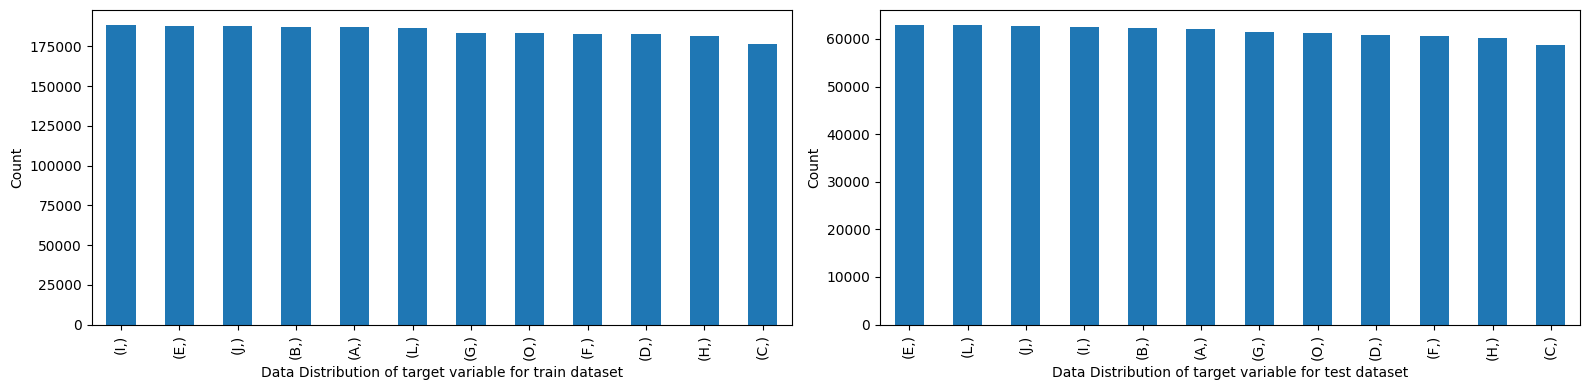

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

# Plot train set
train_set[['Sample']].value_counts().plot.bar(ax=ax[0], legend=False)
ax[0].set_xlabel('Data Distribution of target variable for train dataset')
ax[0].set_ylabel('Count')

# Plot test set
test_set[['Sample']].value_counts().plot.bar(ax=ax[1], legend=False)
ax[1].set_xlabel('Data Distribution of target variable for test dataset')
ax[1].set_ylabel('Count')

plt.tight_layout() 
plt.show()

In [73]:
train_ex = train_set.copy()

# train_ex.info()
# train_ex.describe()

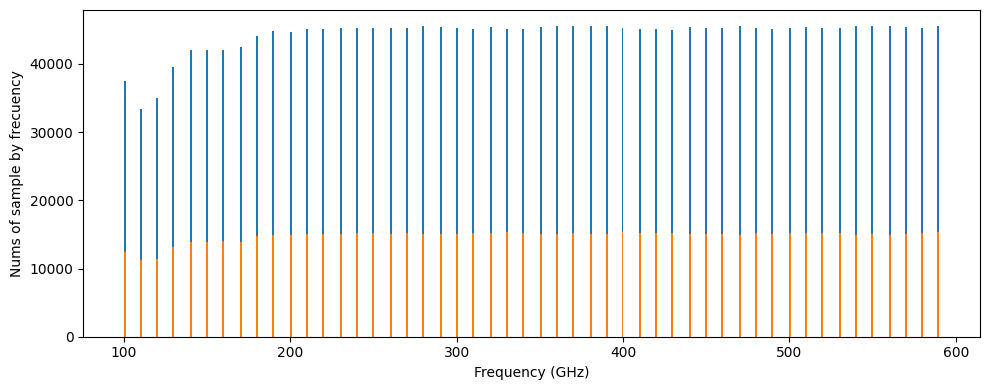

In [74]:
ax = train_ex['Frequency (GHz)'].plot.hist(figsize=(10, 4), bins=408)
ax = test_set['Frequency (GHz)'].plot.hist(ax=ax, bins=408)
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Nums of sample by frecuency')
plt.tight_layout()
plt.show()

In [75]:
# Calculate the percentage of data used for each window
time_window_s = 0.1
stabilised_time_s = 12 * 4
data_percentage = (100/(stabilised_time_s*(1-test_percentage))) * time_window_s
data_percentage_test = (100/(stabilised_time_s*(test_percentage))) * time_window_s

# data_percentage = 100
# data_percentage_test = 100

print(f"Data percentage: {data_percentage}%")
print(f"Data percentage test: {data_percentage_test}%")

# Load just a % of the data
# df_sample = train_set.sample(frac=0.02, random_state=42)


# Introduce Frequency values as input variables
train_set_test = freq_as_variable(train_set, data_percentage)
test_set_test = freq_as_variable(test_set, data_percentage_test)


# If a row has any NaN value, remove that row
train_set_test = train_set_test.dropna()
test_set_test = test_set_test.dropna()

## Save the processed data to a CSV file

# output_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_4_plastics/processed/train_set.csv'
# output_path_test = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_4_plastics/processed/test_set.csv'
# # output_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/train_set.csv'
# # output_path_test = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test_set.csv'

# train_set_test.to_csv(output_path, sep = ';', index=False)
# test_set_test.to_csv(output_path_test, sep = ';', index=False)




Data percentage: 0.2777777777777778%
Data percentage test: 0.8333333333333335%


# Prepare Training Data
## Split the data into X and y


In [76]:
def preprocess_data(df, labels, freqs, eliminate_std_dev=False, eliminate_LG=False, drop_sample=True):
    # Reduce number of different samples for testing
    X_ = df[df['Sample'].isin(labels)]

    y_ = X_['Sample']

    if drop_sample:
        X_ = X_.drop(columns=['Sample'])
        
    if freqs:
        # Subset of specific frequencies to use as input features (or without mean)
        columns = [f'{freq}.0 HG (mV) mean' for freq in freqs] + \
                  [f'{freq}.0 LG (mV) mean' for freq in freqs] + \
                  [f'{freq}.0 HG (mV)' for freq in freqs] + \
                  [f'{freq}.0 LG (mV)' for freq in freqs] + \
                  [f'{freq}.0 HG (mV) std deviation' for freq in freqs] + \
                  [f'{freq}.0 LG (mV) std deviation' for freq in freqs] + \
                  ['Sample']


        # Filter columns that exist in X_
        existing_columns = [col for col in columns if col in X_.columns]

        # Check if existing_columns is empty
        if not existing_columns:
            print("No matching columns found in X_.")
        else:
            X_ = X_[existing_columns]

        # Sort columns by frequency value
        X_ = X_.reindex(sorted(X_.columns), axis=1)

    if eliminate_std_dev:
        # Eliminate std dev columns from the input features
        X_ = X_.drop(columns=[col for col in X_.columns if 'std deviation' in col])

    if eliminate_LG:
        # Eliminate LG columns from the input features
        X_ = X_.drop(columns=[col for col in X_.columns if 'LG' in col])

    return X_, y_


In [77]:
# Subset of specific Samples to use in the training
# labels = ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1', 'K1', 'L1', 'M1', 'N1', 'REF']
# labels = ['B1', 'C1', 'E3', 'REF']
labels = ['B', 'C', 'E', 'R']
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'O']

# Subset of specific frequencies to use as input features, If freqs = [] then all frequencies are used
# freqs = [200,210,230,250,270,280,290,300,310,320,330,360]
# freqs = [200,210,230,250,270,280,290,300,310,320,330,360,340,350,370,380,390,400,410,430,440]
freqs = [250,300,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,510,520,530,540]
# freqs = [310]
freqs = [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 
340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590]

# Count number of frequencies
print(f'freqs number: {len(freqs)}')

# freqs = []

# # Shuffle the data
# train_set_test = train_set_test.sample(frac=1, random_state=42)
# test_set_test = test_set_test.sample(frac=1, random_state=42)

X_train, y_train = preprocess_data(train_set_test, labels, freqs, drop_sample=False, eliminate_std_dev=False) 
X_test, y_test = preprocess_data(test_set_test, labels, freqs, drop_sample=False, eliminate_std_dev=False)

# # Encode the target variable if it's categorical
# if y_train.dtype == 'object':
#     le = LabelEncoder()
#     y_train = le.fit_transform(y_train)

# if y_test.dtype == 'object':
#     y_test = le.transform(y_test)


# # le is the fitted LabelEncoder - Saving Encoder
# joblib.dump(le, 'label_encoder.pkl')

# # Standardize the data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Remove sample columns
X_train = X_train.drop(columns=['Sample'])
X_test = X_test.drop(columns=['Sample'])

print(X_train)


freqs number: 50
      100.0 HG (mV) mean  100.0 HG (mV) std deviation  100.0 LG (mV) mean  \
0              33.871864                     6.454981           -0.325561   
1              25.570070                    10.692935            0.027130   
2              30.412783                     8.018556           -0.474776   
3              26.343276                     7.127304           -0.149215   
4              25.190249                    10.137301           -0.135650   
...                  ...                          ...                 ...   
4794           24.920644                    12.070207            0.228910   
4795           21.059699                     8.906605           -0.030521   
4796           22.799414                    10.041940            0.320474   
4797           22.021120                     9.449007            0.183128   
4798           24.050787                    10.211880           -0.076303   

      100.0 LG (mV) std deviation  110.0 HG (mV) mean  \
0

In [ ]:
#### TBD ####
# FEATURE TRANSFORMATIONS
# feature engineering transformation with autofeat
# from autofeat import AutoFeatClassifier
# from autofeat import AutoFeatRegressor

### Principal Component Analysis

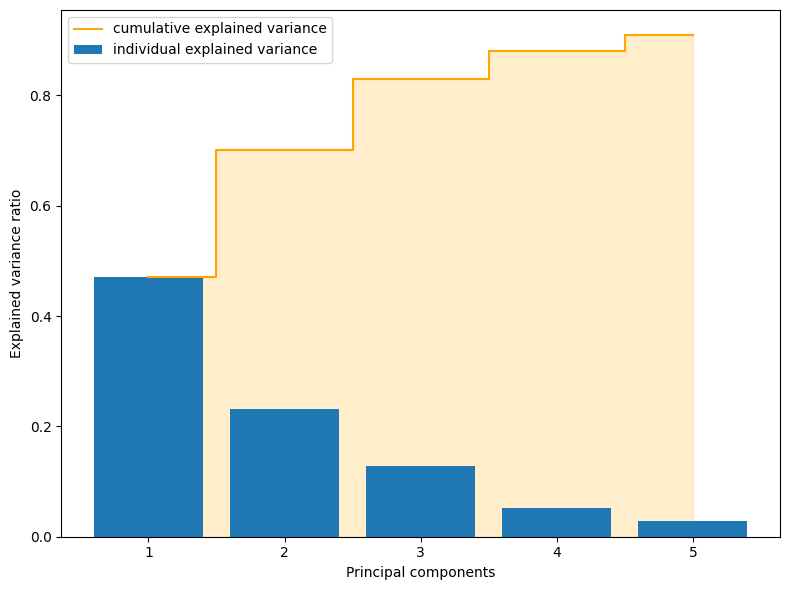

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not 0       A
1       A
2       A
3       A
4       A
       ..
4794    O
4795    O
4796    O
4797    O
4798    O
Name: Sample, Length: 4396, dtype: object

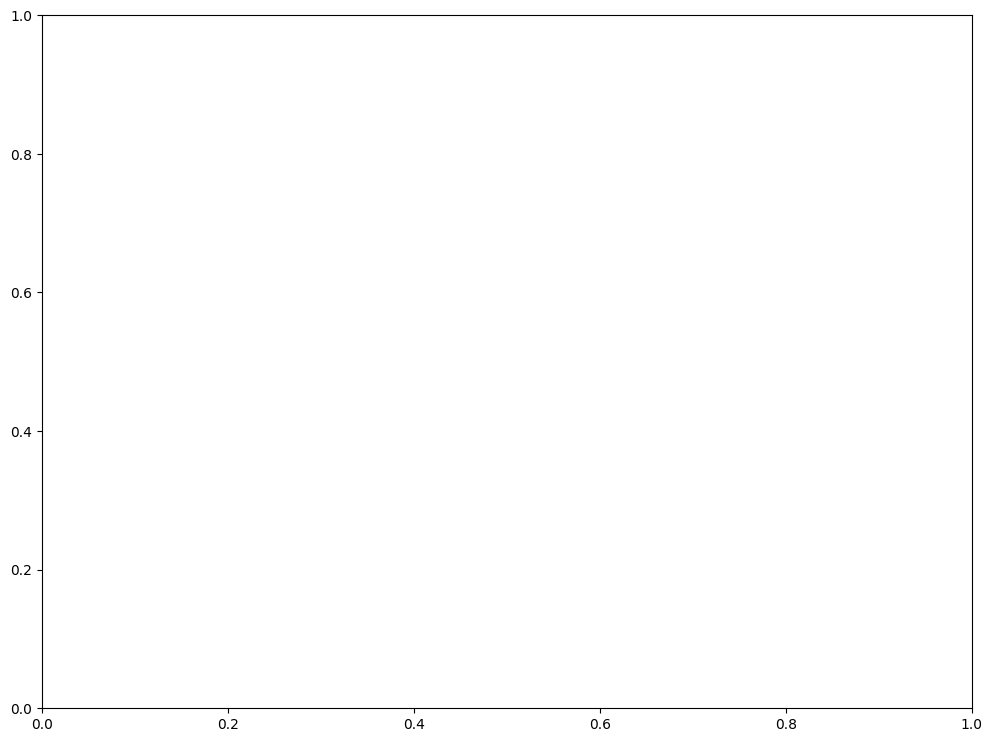

In [78]:
# Apply PCA
n_components = 5
pca = PCA(n_components)  # Reduce to 2 components for visualization
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
y_pca = y_train

# Plot the explained variance ratio
plt.figure(figsize=(8, 6))
plt.step(range(1, n_components+1), np.cumsum(pca.explained_variance_ratio_), where='mid', label='cumulative explained variance', color='orange')
plt.fill_between(range(1, n_components+1), np.cumsum(pca.explained_variance_ratio_), step='mid', alpha=0.2, color='orange')
plt.bar(range(1, n_components+1), pca.explained_variance_ratio_, alpha=1.0, align='center', label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


### VISUALIZATION ###
# Plot the PCA components (first two components for visualization)
plt.figure(figsize=(12, 9))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_pca, cmap = 'tab20',
                      edgecolor='k', s=25)
# Produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# Show a class label on the data points (just one label per class in total)
offset = 10
for i, label in enumerate(labels):
    plt.text(X_train_pca[y_pca == i, 0].mean() , X_train_pca[y_pca == i, 1].mean() + offset, label,
             ha='center', va='center', size=8, bbox=dict(facecolor='w', alpha=0.6))


plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('PCA of Training Data')


plt.show()


# Show how the principal components are related to the original features
# Create a DataFrame with the PCA components
components = pd.DataFrame(pca.components_, columns=X_train.columns)
# Transpose the DataFrame
components = components.T
# Display the highest and lowest n variables of the first 3 components
n= 10
for i in range(n_components):
    print(f"Component {i+1}:")
    print(components[i].nlargest(n), '\n')
    print(components[i].nsmallest(n), '\n')


## NON PCA VISUALIZATION ##
# Choose specific variables for visualization
var1 = '410.0 HG (mV)'
var2 = '360.0 HG (mV)'
# var2 = '320.0 HG (mV) std deviation'

try:
    X_train[var1].describe()
except Exception as e:
    var1 = f'{var1} mean'
    var2 = f'{var2} mean'

# Plot the chosen input variables for visualization
plt.figure(figsize=(12, 9))
scatter = plt.scatter(X_train[var1], X_train[var2], c=y_train, cmap='tab20',
                      edgecolor='k', s=25)
# Produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# Show a class label on the data points (just one label per class in total)
offset = 0
unique_labels = np.unique(y_train)
for i, label in enumerate(unique_labels):
    plt.text(X_train[y_train == label][var1].mean(), X_train[y_train == label][var2].mean() + offset, 
             labels[label], ha='center', va='center', size=8, bbox=dict(facecolor='w', alpha=0.6))

plt.xlabel(var1)
plt.ylabel(var2)
plt.title('Scatter Plot of Chosen Input Variables')

plt.show()



In [79]:
# Model Parameters
input_size = X_train.shape[1]
output_size = len(np.unique(y_train))
seed = set_seed(42)

input_size, output_size

X_train.head(5)


,100.0 HG (mV) mean,100.0 HG (mV) std deviation,100.0 LG (mV) mean,100.0 LG (mV) std deviation,110.0 HG (mV) mean,110.0 HG (mV) std deviation,110.0 LG (mV) mean,110.0 LG (mV) std deviation,120.0 HG (mV) mean,120.0 HG (mV) std deviation,...,570.0 LG (mV) mean,570.0 LG (mV) std deviation,580.0 HG (mV) mean,580.0 HG (mV) std deviation,580.0 LG (mV) mean,580.0 LG (mV) std deviation,590.0 HG (mV) mean,590.0 HG (mV) std deviation,590.0 LG (mV) mean,590.0 LG (mV) std deviation
0,33.871864,6.454981,-0.325561,0.929773,0.488336,0.233759,47.752759,14.579590,0.034853,0.818102,...,-0.170920,0.676567,37.443535,8.000293,0.695886,0.861448,32.975216,8.633582,0.183128,1.328992
1,25.570070,10.692935,0.027130,1.169054,-0.000017,0.602234,46.061007,19.181723,-0.348820,0.750692,...,-0.195336,1.058385,37.126113,5.031218,0.280796,1.064392,29.483579,8.680031,-0.134294,0.875559
2,30.412783,8.018556,-0.474776,1.610929,-0.191839,0.891173,48.694560,18.010697,-0.401129,1.153313,...,-0.329630,0.990238,25.833231,8.020378,-0.024417,1.133341,33.622268,9.975723,-0.158711,0.681080
3,26.343276,7.127304,-0.149215,0.879899,0.087207,0.830176,48.310863,10.686400,0.017442,0.985360,...,0.610426,1.037525,30.228299,8.142513,0.207545,1.609437,30.521303,10.455228,-0.061043,1.234678
4,25.190249,10.137301,-0.135650,1.392580,0.156978,1.226355,62.995971,12.828827,-0.104642,1.072277,...,-0.341838,1.428159,34.684409,7.542203,-0.231962,1.101702,29.520204,14.484908,0.329630,1.260956


### Define Models
- Random Forest
- Naive-Bayes
- Logistic Regression
- Gradient Boosting

In [80]:
def random_forest_model(X_train, y_train, seed):
    rf_model = RandomForestClassifier(random_state=seed)
    rf_model.fit(X_train, y_train)
    return rf_model

def naive_bayes_model(X_train, y_train):
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    return nb_model

def logistic_regression_model(X_train, y_train, seed):
    lr_model = LogisticRegression(max_iter=10000, random_state=seed)
    lr_model.fit(X_train, y_train)
    return lr_model

def gradient_boosting_model(X_train, y_train, seed):
    gb_model = GradientBoostingClassifier(n_estimators=10, random_state=seed)
    gb_model.fit(X_train, y_train)
    return gb_model

### Train all Models

In [81]:
def train_models(X_train, y_train, seed):
    rf_model = random_forest_model(X_train, y_train, seed)
    nb_model = naive_bayes_model(X_train, y_train)
    lr_model = logistic_regression_model(X_train, y_train, seed)
    gb_model = gradient_boosting_model(X_train, y_train, seed)
    return rf_model, nb_model, lr_model, gb_model

def save_models(rf_model, nb_model, lr_model, gb_model):
    joblib.dump(rf_model, 'random_forest_model.pkl')
    joblib.dump(nb_model, 'naive_bayes_model.pkl')
    joblib.dump(lr_model, 'logistic_regression_model.pkl')
    joblib.dump(gb_model, 'gradient_boosting_model.pkl')

In [82]:
# Function to apply confidence threshold
def apply_confidence_threshold(probabilities, threshold=0.7):
    max_probs = np.max(probabilities, axis=1)
    predictions = np.argmax(probabilities, axis=1)
    # Replace predictions with -1 (unknown) where confidence is below threshold
    predictions[max_probs < threshold] = -1
    return predictions, max_probs


In [83]:
# AIC Criteria
def aic_score(y_true, y_pred, n_features):
    n = len(y_true)
    residuals = y_true - y_pred
    rss = np.sum(residuals**2)
    epsilon = 1e-10  # Small value to avoid log(0)
    aic = 2 * n_features + n * np.log((rss + epsilon) / n)
    return aic

# BIC Criteria (Also consider the number of samples)
def bic_score(y_true, y_pred, n_features):
    n = len(y_true)
    residuals = y_true - y_pred
    rss = np.sum(residuals**2)
    epsilon = 1e-10  # Small value to avoid log(0)
    bic = np.log(n) * n_features + n * np.log((rss + epsilon) / n)
    return bic

In [84]:
def save_model_results(models, data, accuracies, precisions, recalls, f1_scores, predictions, n_features, freqs, 
                      aic_scores, bic_scores, csv_path='comparison_results.csv', verbose=0):
    
    # Determine test number
    if os.path.exists(csv_path):
        existing_results = pd.read_csv(csv_path, sep=';')
        current_test = existing_results['Test'].max() + 1
    else:
        current_test = 1

    # Create results DataFrame
    results_df = pd.DataFrame({
        'Test': [current_test] * len(models),
        'Data': [data] * len(models),
        'Accuracy': accuracies,
        'Precision': precisions,
        'Recall': recalls,
        'F1-Score': f1_scores,
        'AIC': aic_scores,
        'BIC': bic_scores,
        'Predictions': predictions,
        'Algorithm': models,
        'Num_Features': [n_features] * len(models),
        'Num Frequencies': [len(freqs)] * len(models),
        'Frequencies': [', '.join([f"{freq:.0f}" for freq in freqs])] * len(models)
    })

    # Format float columns
    float_columns = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AIC', 'BIC']
    results_df[float_columns] = results_df[float_columns].round(4)

    # Append or create results file
    if os.path.exists(csv_path):
        updated_results = pd.concat([existing_results, results_df], ignore_index=True)
    else:
        updated_results = results_df

    # Save updated results
    updated_results.to_csv(csv_path, index=False, sep=';')

    if verbose >= 1:
        print(f"\nTest #{current_test} Results:")
        print(results_df)
        if verbose >= 2:
            print("\nAll Results:")
            print(updated_results)
        
    return updated_results

In [85]:
def evaluate_models(y_test, y_pred, verbose=0):
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    aic_scores = []
    bic_scores = []
    predictions_list = []

    for i, y_pred_i in enumerate(y_pred):
        accuracy = accuracy_score(y_test, y_pred_i)
        precision = precision_score(y_test, y_pred_i, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred_i, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred_i, average='weighted', zero_division=0)

        # Calculate AIC and BIC
        y_test_num = le.transform(y_test)
        y_pred_num = le.transform(y_pred_i)
        n_features = len(y_pred_i)
        aic = aic_score(y_test_num, y_pred_num, n_features)
        bic = bic_score(y_test_num, y_pred_num, n_features)

        print(f"Model {i+1} - Accuracy: {accuracy}")
        print(f"Model {i+1} - Precision: {precision}")
        print(f"Model {i+1} - Recall: {recall}")
        print(f"Model {i+1} - F1: {f1}")
        print(f"Model {i+1} - AIC: {aic}")
        print(f"Model {i+1} - BIC: {bic}")


        # Predictions made per class with its label encoded value
        predictions = dict(sorted(Counter(y_pred_i).items()))

        if verbose >= 1:
            print(f"Model {i+1} - Predictions: {predictions}\n")
            if verbose >= 2:
                # Classification report
                print(f"Model {i+1} - Classification Report:\n", classification_report(y_test, y_pred_i), '\n')


        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        aic_scores.append(aic)
        bic_scores.append(bic)
        predictions_list.append(predictions)

    return accuracies, precisions, recalls, f1_scores, aic_scores, bic_scores, predictions_list

In [86]:
def get_feature_importances(rf_model, lr_model, gb_model, nb_model, X_train, y_train, seed, plot=False, n=30):
    feature_names = X_train.columns

    # Random Forest feature importances
    rf_feature_importances = rf_model.feature_importances_
    rf_feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_feature_importances})
    rf_feature_importances_df = rf_feature_importances_df.sort_values('Importance', ascending=False)

    # Logistic Regression feature importances
    lr_feature_importances = lr_model.coef_[0]
    lr_feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': lr_feature_importances})
    lr_feature_importances_df = lr_feature_importances_df.sort_values('Importance', ascending=False)

    # Gradient Boosting feature importances
    gb_feature_importances = gb_model.feature_importances_
    gb_feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': gb_feature_importances})
    gb_feature_importances_df = gb_feature_importances_df.sort_values('Importance', ascending=False)

    # Naive Bayes permutation importance
    result = permutation_importance(nb_model, X_train, y_train, n_repeats=5, random_state=seed, n_jobs=1)
    sorted_idx = result.importances_mean.argsort()[::-1]
    nb_feature_importances_df = pd.DataFrame({'Feature': feature_names[sorted_idx], 'Importance': result.importances_mean[sorted_idx]})

    if plot:
        # Font size
        plt.rcParams.update({'font.size': 6})

        # Plot the feature importances
        plt.figure(figsize=(20, 10))
        plt.barh(rf_feature_importances_df['Feature'][:n], rf_feature_importances_df['Importance'][:n])
        plt.xlabel('Importance')
        plt.title('Random Forest Feature Importances')
        plt.show()

        plt.figure(figsize=(20, 10))
        plt.barh(lr_feature_importances_df['Feature'][:n], lr_feature_importances_df['Importance'][:n])
        plt.xlabel('Importance')
        plt.title('Logistic Regression Feature Importances')
        plt.show()

        plt.figure(figsize=(20, 10))
        plt.barh(gb_feature_importances_df['Feature'][:n], gb_feature_importances_df['Importance'][:n])
        plt.xlabel('Importance')
        plt.title('Gradient Boosting Feature Importances')
        plt.show()

        plt.figure(figsize=(12, 8))
        plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])
        plt.xlabel('Permutation Importance')
        plt.title('Naive Bayes Permutation Feature Importance')
        plt.show()

    return rf_feature_importances_df, lr_feature_importances_df, gb_feature_importances_df, nb_feature_importances_df


In [87]:
# Train the models
rf_model, nb_model, lr_model, gb_model = train_models(X_train, y_train, seed)

# Make Predictions

y_pred = []
y_pred.append(rf_model.predict(X_test))
y_pred.append(nb_model.predict(X_test))
y_pred.append(lr_model.predict(X_test))
y_pred.append(gb_model.predict(X_test))

print(y_pred)
print(y_test)
print(y_train)



# Call the function
accuracies, precisions, recalls, f1_scores, aic_scores, bic_scores, predictions = evaluate_models(y_test, y_pred, verbose=2)

# Define model names
models = ['RF', 'NB', 'LR', 'GB']

# # Get feature importance values
# rf_feature_importances_df, lr_feature_importances_df, gb_feature_importances_df, nb_feature_importances_df = get_feature_importances(
#     rf_model, lr_model, gb_model, nb_model, X_train, y_train, seed, plot=False, n=30)

##TBD 
# - ADD FEATURE IMPORTANCE TO CSV - HOW?

updated_results = save_model_results(
    models=models,
    data='Test',
    accuracies=accuracies,
    precisions=precisions,
    recalls=recalls,
    f1_scores=f1_scores,
    aic_scores=aic_scores,
    bic_scores=bic_scores,
    predictions=predictions,
    n_features=X_train.shape[1],
    freqs=freqs
)


[array(['A', 'A', 'A', ..., 'O', 'O', 'O'], dtype=object), array(['A', 'A', 'A', ..., 'O', 'O', 'O'], dtype='<U1'), array(['A', 'A', 'A', ..., 'O', 'O', 'O'], dtype=object), array(['A', 'A', 'A', ..., 'O', 'O', 'O'], dtype=object)]
0       A
1       A
2       A
3       A
4       A
       ..
1601    O
1602    O
1603    O
1604    O
1605    O
Name: Sample, Length: 1445, dtype: object
0       A
1       A
2       A
3       A
4       A
       ..
4794    O
4795    O
4796    O
4797    O
4798    O
Name: Sample, Length: 4396, dtype: object
Model 1 - Accuracy: 1.0
Model 1 - Precision: 1.0
Model 1 - Recall: 1.0
Model 1 - F1: 1.0
Model 1 - AIC: -40895.9789415537
Model 1 - BIC: -33272.35459376396
Model 1 - Predictions: {'A': 120, 'B': 121, 'C': 120, 'D': 120, 'E': 121, 'F': 120, 'G': 120, 'H': 121, 'I': 120, 'J': 121, 'L': 121, 'O': 120}

Model 1 - Classification Report:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00       120
           B       1

PermissionError: [Errno 13] Permission denied: 'comparison_results.csv'

## Threshold for Unknown class

In [231]:
# Get predictions and probabilities
rf_probs = rf_model.predict_proba(X_test)
nb_probs = nb_model.predict_proba(X_test)
lr_probs = lr_model.predict_proba(X_test)
gb_probs = gb_model.predict_proba(X_test)

# Apply thresholding
thresholds = [0.5, 0.7, 0.9]
models = ['RF', 'NB', 'LR', 'GB']
prob_list = [rf_probs, nb_probs, lr_probs, gb_probs]

for threshold in thresholds:
    print(f"\nResults with confidence threshold = {threshold}")
    print("-" * 50)
    
    for model_name, probs in zip(models, prob_list):
        predictions, confidences = apply_confidence_threshold(probs, threshold)
        
        # Convert -1 to 'unknown' for metrics
        valid_mask = predictions != -1
        
        if np.any(valid_mask):
            # Calculate metrics only on predictions above threshold
            accuracy = accuracy_score(y_test[valid_mask], predictions[valid_mask])
            precision = precision_score(y_test[valid_mask], predictions[valid_mask], 
                                     average='weighted', zero_division=0)
            recall = recall_score(y_test[valid_mask], predictions[valid_mask], 
                                average='weighted',zero_division=0)
            
            print(f"\n{model_name}:")
            print(f"Samples retained: {sum(valid_mask)}/{len(predictions)} "
                  f"({100*sum(valid_mask)/len(predictions):.1f}%)")
            print(f"Accuracy: {accuracy:.3f}")
            print(f"Precision: {precision:.3f}")
            print(f"Recall: {recall:.3f}")
            
            # Plot confidence distribution
            plt.figure(figsize=(8, 4))
            plt.hist(confidences, bins=50)
            plt.axvline(x=threshold, color='r', linestyle='--', 
                       label=f'Threshold ({threshold})')
            plt.title(f'Confidence Distribution - {model_name}')
            plt.xlabel('Confidence Score')
            plt.ylabel('Count')
            plt.legend()
            plt.show()

print(rf_probs)


Results with confidence threshold = 0.5
--------------------------------------------------


ValueError: Mix of label input types (string and number)

In [ ]:
## Export Random Forest model with graphviz
def export_random_forest_model(rf_model, feature_names, output_file='random_forest_model'):
    # Export the first tree in the Random Forest
    dot_data = export_graphviz(
        rf_model.estimators_[0], 
        out_file=None, 
        filled=True, 
        rounded=True, 
        special_characters=True,
        feature_names=feature_names
    )

    # Create a graph from the dot data
    graph = graphviz.Source(dot_data)

    # Render the graph to a file
    graph.render(output_file)

feature_names = X_train.columns.tolist()  # Replace with actual feature names
# Call the function
export_random_forest_model(rf_model, feature_names)


'random_forest_model.pdf'

## Confusion Matrix

In [88]:
## Confusion matrix with matplotlib
def plot_confusion_matrix(y_true, y_pred, labels):
    conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, f'{conf_matrix[i, j]}\n({conf_matrix[i, j] / np.sum(conf_matrix, axis=1)[i] * 100:.1f}%)',
                     horizontalalignment="center",
                     verticalalignment="center",
                     fontsize=9,
                     ha='center', va='center', color='white')
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(np.arange(len(labels)), labels, rotation=45)
    plt.yticks(np.arange(len(labels)), labels)
    plt.title('Confusion Matrix')
    plt.show()


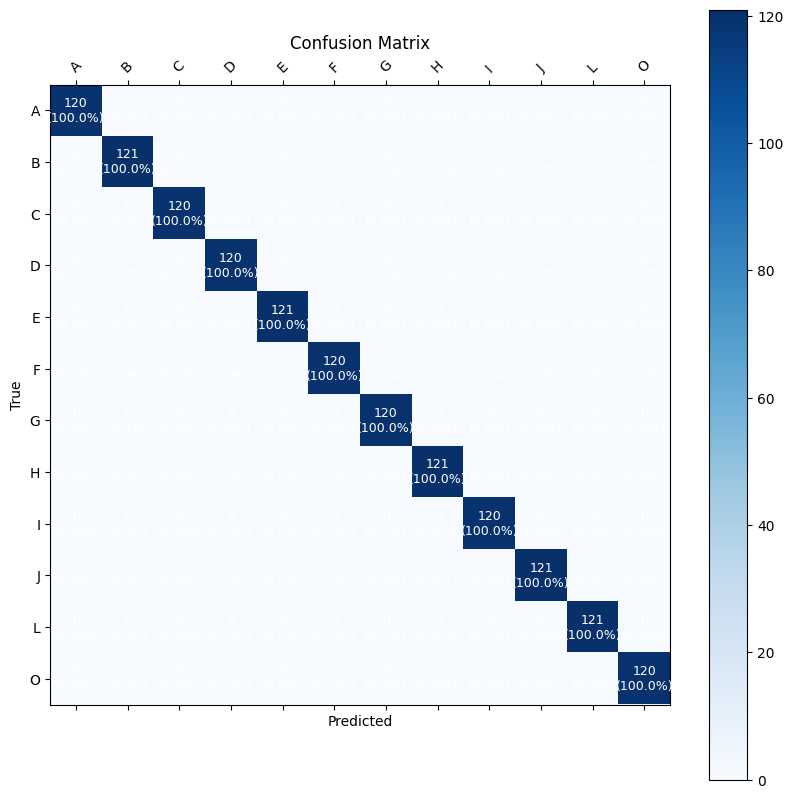

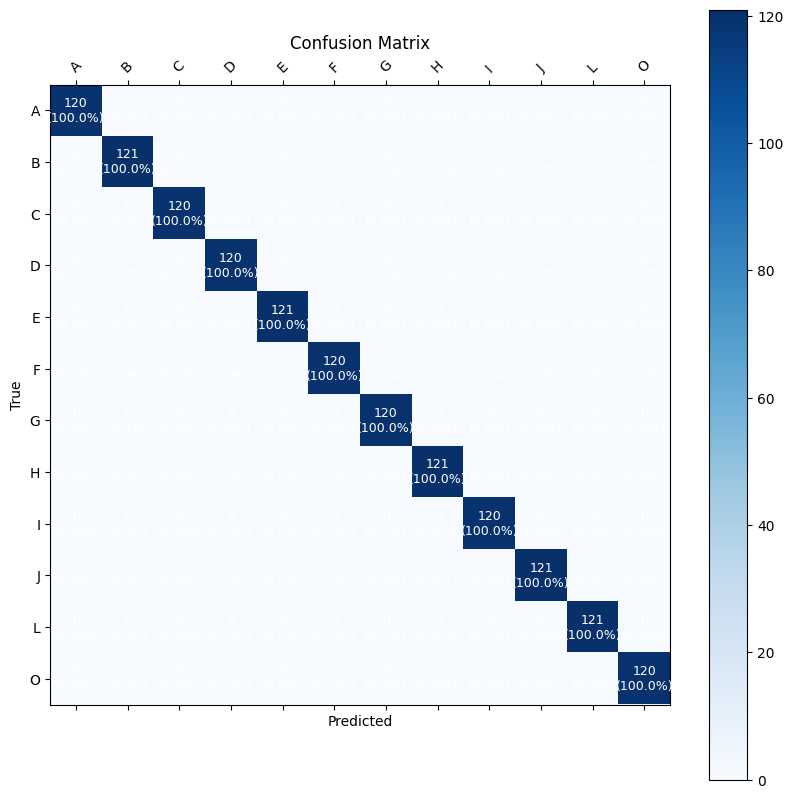

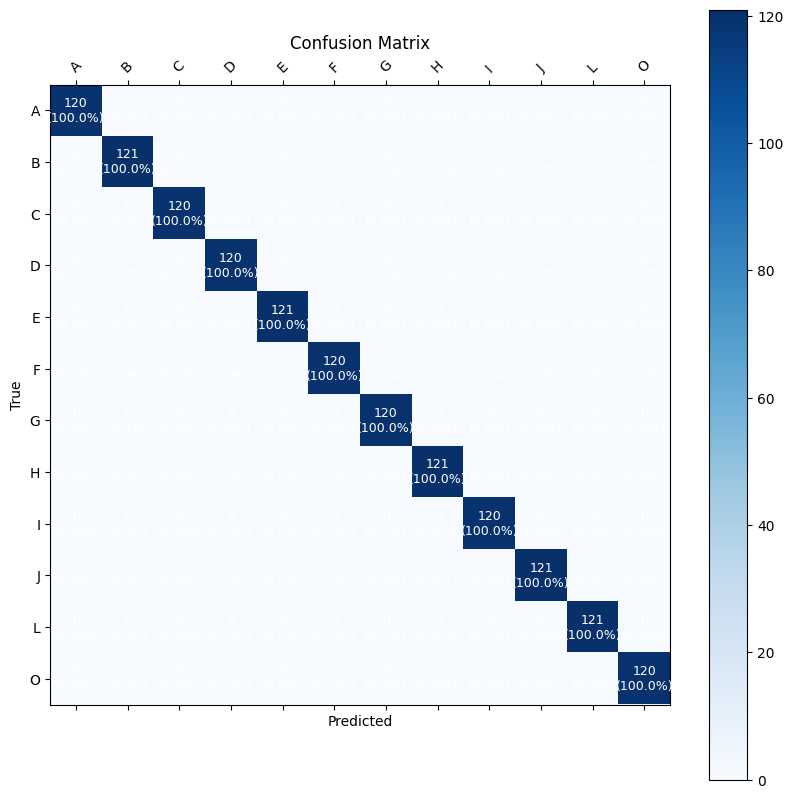

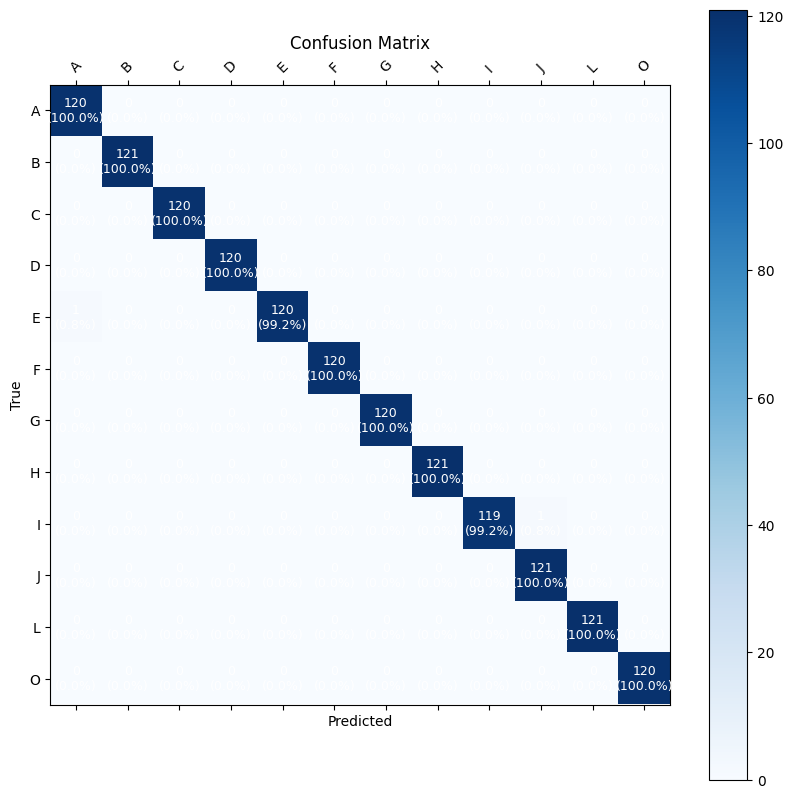

In [89]:
plot_confusion_matrix(y_test, y_pred[0], np.unique(y_test))
plot_confusion_matrix(y_test, y_pred[1], np.unique(y_test))
plot_confusion_matrix(y_test, y_pred[2], np.unique(y_test))
plot_confusion_matrix(y_test, y_pred[3], np.unique(y_test))

## Load and preprocess Other Test Data (Experiment 4)
Prepare new sample for testing (Testing other samples, out of initial dataset)

In [90]:
def add_features(X, y, subset_freqs, HG_diff=True, LG_diff=True):

    X['Sample'] = y

    # Initialize a dictionary to store results
    mean_std_dict = {}

    for freq in subset_freqs:
        # Calculate HG and LG mean values for each frequency
        agg_dict = {}
        if f'{freq}.0 LG (mV) mean' in X.columns:
            agg_dict['LG_mean'] = (f'{freq}.0 LG (mV) mean', 'mean')
        if f'{freq}.0 HG (mV) mean' in X.columns:
            agg_dict['HG_mean'] = (f'{freq}.0 HG (mV) mean', 'mean')
        
        mean_std_dict[freq] = X.groupby('Sample').agg(**agg_dict).reset_index()

        mean_std_dict[freq]['Frequency'] = freq

    # Concatenate all DataFrames in the dictionary
    mean_std_df = pd.concat(mean_std_dict.values(), ignore_index=True)

    # For each frequency after first one
    for i, freq in enumerate(subset_freqs[1:]):
        prev_freq = subset_freqs[i]  # Get previous frequency
        
        # For each row
        for idx, row in X.iterrows():
            sample = row['Sample']
            
            if HG_diff:
                # Get previous frequency's HG mean for this sample
                prev_hg = mean_std_df[
                    (mean_std_df['Frequency'] == prev_freq) & 
                    (mean_std_df['Sample'] == sample)
                ]['HG_mean'].values[0]


                # 1) Inputs: xt - (xt-1) --First-order differences
                # 2) Inputs: (xt/(xt-1)) - 1 --Escalado relativo

                # Calculate and store difference
                X.loc[idx, f'{freq}.0 HG diff'] = X.loc[idx, f'{freq}.0 HG (mV) mean'] - prev_hg
                # X.loc[idx, f'{freq}.0 HG relative diff'] = (X.loc[idx, f'{freq}.0 HG (mV) mean'] / prev_hg) -1


            if LG_diff:
                prev_lg = mean_std_df[
                    (mean_std_df['Frequency'] == prev_freq) & 
                    (mean_std_df['Sample'] == sample)
                ]['LG_mean'].values[0]

                # Calculate and store difference
                # X.loc[idx, f'{freq}.0 LG diff'] = X.loc[idx, f'{freq}.0 LG (mV) mean'] - prev_lg
                X.loc[idx, f'{freq}.0 LG relative diff'] = (X.loc[idx, f'{freq}.0 LG (mV) mean'] / prev_lg) -1
    
    


    # Drop the 'Sample' column
    X = X.drop(columns=['Sample'])

    return X
  

In [91]:
# input_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_2_plastics/processed/test/'
input_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_5_plastics/processed/new_sample/'

df_new_sample = load_data_from_directory(input_path)
df_new_sample = pd.concat([df_new_sample[['Frequency (GHz)', 'LG (mV)', 'HG (mV)']], df_new_sample[['Sample']]], axis=1)

df_new_sample['Sample'] = df_new_sample['Sample'].str[0]
print(df_new_sample.head(10))

# Calculate the percentage of data used for each window
time_window_s = 0.1
stabilised_time_s = 12 * 1
data_percentage = (100/(stabilised_time_s*(1-test_percentage))) * time_window_s
data_percentage_test = (100/(stabilised_time_s*(test_percentage))) * time_window_s

print(f"Data percentage: {data_percentage}%")
print(f"Data percentage test: {data_percentage_test}%")

# Introduce Frequency values as input variables
df_new_sample = freq_as_variable(df_new_sample, data_percentage) # 0.22

# If a row has any NaN value, remove that row
df_new_sample = df_new_sample.dropna()

print(f"New sample shape: {df_new_sample.shape}")
# print(f"X_shape: {X_train.shape}")

# load the label encoder
le = joblib.load('label_encoder.pkl')

   Frequency (GHz)   LG (mV)    HG (mV) Sample
0            100.0 -1.098767  45.659870      A
1            100.0 -0.854596  32.718837      A
2            100.0 -1.220852  22.829935      A
3            100.0  0.610426  37.846416      A
4            100.0 -0.488341  20.266145      A
5            100.0 -0.244170  22.463679      A
6            100.0 -0.732511  24.539128      A
7            100.0 -1.465023  28.934196      A
8            100.0 -0.488341  25.882065      A
9            100.0  1.098767  46.026126      A
Data percentage: 1.1111111111111112%
Data percentage test: 3.333333333333334%
New sample shape: (1083, 201)


## Define training and testing data

In [92]:
labels = ['B', 'C', 'E', 'R']
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'O']


# Subset of specific frequencies to use as input features, If freqs = [] then all frequencies are used

# Favourite frequencies
freqs_fav = [250,300,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,510,520,530,540]
# freqs_fav = [340,360,370,380,390,400,410,420]
# # Count number of frequencies
# print(f'freqs number: {len(freqs)}')

# Array with subsets of frequencies to use for training
freqs = [
        [250, 300, 320],
        [330, 340, 350],
        [360, 370, 380],
        [390, 400, 410],
        [420, 430, 440],
        [450, 460, 470],
        [480, 490, 500],
        [510, 520, 530, 540]
    ]

freqs.append(freqs_fav)

# Add all frequencies one by one
for i in range(100, 591, 10):
    freqs.append([i])

# Add groups of 2 frequencies
for i in range(100, 591, 20):
    if i + 10 <= 590:
        freqs.append([i, i+10])

# Add groups of 3 frequencies
for i in range(100, 591, 30):
    if i + 20 <= 590 and i + 10 <= 590:
        freqs.append([i, i+10, i+20])

# Add a group with all frequencies from 100 to 590
freqs.append(list(range(100, 591, 10)))

freqs.append([250,320,330,410])

print(freqs)

[[250, 300, 320], [330, 340, 350], [360, 370, 380], [390, 400, 410], [420, 430, 440], [450, 460, 470], [480, 490, 500], [510, 520, 530, 540], [250, 300, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540], [100], [110], [120], [130], [140], [150], [160], [170], [180], [190], [200], [210], [220], [230], [240], [250], [260], [270], [280], [290], [300], [310], [320], [330], [340], [350], [360], [370], [380], [390], [400], [410], [420], [430], [440], [450], [460], [470], [480], [490], [500], [510], [520], [530], [540], [550], [560], [570], [580], [590], [100, 110], [120, 130], [140, 150], [160, 170], [180, 190], [200, 210], [220, 230], [240, 250], [260, 270], [280, 290], [300, 310], [320, 330], [340, 350], [360, 370], [380, 390], [400, 410], [420, 430], [440, 450], [460, 470], [480, 490], [500, 510], [520, 530], [540, 550], [560, 570], [580, 590], [100, 110, 120], [130, 140, 150], [160, 170, 180], [190, 200, 210], [220, 230, 24

In [94]:
print(f'X_train : {X_train}')

X_train :       100.0 HG (mV) mean  100.0 HG (mV) std deviation  100.0 LG (mV) mean  \
0              33.871864                     6.454981           -0.325561   
1              25.570070                    10.692935            0.027130   
2              30.412783                     8.018556           -0.474776   
3              26.343276                     7.127304           -0.149215   
4              25.190249                    10.137301           -0.135650   
...                  ...                          ...                 ...   
4794           24.920644                    12.070207            0.228910   
4795           21.059699                     8.906605           -0.030521   
4796           22.799414                    10.041940            0.320474   
4797           22.021120                     9.449007            0.183128   
4798           24.050787                    10.211880           -0.076303   

      100.0 LG (mV) std deviation  110.0 HG (mV) mean  \
0       

In [102]:
def inference_sampling(predictions):
    """
    Takes a list of predictions and returns the most common value
    
    Args:
        predictions: List of prediction values
        
    Returns:
        Most frequent prediction value
    """
    if not predictions:
        return None
        
    # Count frequency of each prediction
    freq_dict = {}
    for pred in predictions:
        freq_dict[pred] = freq_dict.get(pred, 0) + 1
    
    # Find value with highest frequency
    max_freq = 0
    mode = None
    for value, freq in freq_dict.items():
        if freq > max_freq:
            max_freq = freq
            mode = value
            
    return mode

### Use probabilities with inference_sampling? threshold?

In [103]:
def predict_with_probabilities(model, X):
    """
    Perform inference on the dataset using the trained model and return predictions with probabilities.

    Parameters:
    model: Trained model object with predict and predict_proba methods.
    X: Dataset to perform inference on.

    Returns:
    predictions: Array of predicted class labels.
    probabilities: Array of predicted probabilities for each class.
    """
    # Predict class labels
    predictions = model.predict(X)
    
    # Predict probabilities
    probabilities = model.predict_proba(X)
    
    return predictions, probabilities

In [104]:
def evaluate_models_with_sampling(models, X, y_true):
    """
    Evaluate multiple models using inference sampling
    
    Args:
        models: List of trained model objects
        X: Features dataset
        y_true: True labels
        
    Returns:
        Dictionary with evaluation metrics
    """
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    # Get predictions from each model
    all_predictions = []
    for model in models:
        preds, _ = predict_with_probabilities(model, X)
        all_predictions.append(preds)
    
    # Get final predictions using sampling
    final_predictions = []
    for i in range(len(X)):
        sample_preds = [pred[i] for pred in all_predictions]
        final_pred = inference_sampling(sample_preds)
        final_predictions.append(final_pred)
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_true, final_predictions),
        'precision': precision_score(y_true, final_predictions, average='weighted'),
        'recall': recall_score(y_true, final_predictions, average='weighted'),
        'f1': f1_score(y_true, final_predictions, average='weighted')
    }
    
    return metrics

## Notes
- 01. 0.32159
- 02. 0.29434 - Removing LG barely affects the results, in some cases even improve the results.
- 03. 0.32377 - Without std deviation good results are obtained in different frequencies than the original model.
- 04. 0.31058 - Results with relative scaling are not considerably better in general. With 1 frequency results are the same as with one frequency only since the data is the same
- 05. 0.31136 - Results with first order difference are not considerably better in general. With 1 frequency results are the same as with one frequency only since the data is the same. It is slightly better in RF models.


## Testing

In [101]:
csv_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/results/exp_5/06_HG_LG_1storder_diff_results_12p.csv'

for freq in freqs:

    subset_freqs = freq
    print(f'Frequency: {freq}')

    # Training options
    drop_sample = True
    eliminate_std_dev = False
    eliminate_LG = False
    HG_diff = True
    LG_diff = True

    X_train, y_train = preprocess_data(train_set_test, labels, subset_freqs, eliminate_std_dev, eliminate_LG, drop_sample=True) 
    X_test, y_test = preprocess_data(test_set_test, labels, subset_freqs, eliminate_std_dev, eliminate_LG, drop_sample=True)

    X_train = add_features(X_train, y_train, subset_freqs, HG_diff, LG_diff)
    X_test = add_features(X_test, y_test, subset_freqs, HG_diff, LG_diff)

    # Define model names
    models = ['RF', 'NB', 'LR', 'GB']

    # Train the models
    rf_model, nb_model, lr_model, gb_model = train_models(X_train, y_train, seed)

    # # Make Predictions
    # Make Predictions
    y_pred = [
        rf_model.predict(X_test),
        nb_model.predict(X_test),
        lr_model.predict(X_test),
        gb_model.predict(X_test)
    ]
        
    # Evaluate Models
    accuracies, precisions, recalls, f1_scores, aic_scores, bic_scores, predictions = evaluate_models(y_test, y_pred, verbose=0)

    updated_results = save_model_results(
        models=models,
        data='test',
        accuracies=accuracies,
        precisions=precisions,
        recalls=recalls,
        f1_scores=f1_scores,
        aic_scores=aic_scores,
        bic_scores=bic_scores,
        predictions=predictions,
        n_features=X_train.shape[1],
        freqs=subset_freqs,
        csv_path=csv_path
    )


    X_new_sample, y_new_sample = preprocess_data(df_new_sample, labels, subset_freqs, eliminate_std_dev, eliminate_LG, drop_sample=True )

    X_new_sample = add_features(X_new_sample, y_new_sample, subset_freqs, HG_diff, LG_diff)

    # Make Predictions
    y_pred_ns = [
        rf_model.predict(X_new_sample),
        nb_model.predict(X_new_sample),
        lr_model.predict(X_new_sample),
        gb_model.predict(X_new_sample)
    ]

    # Evaluate Models
    accuracies, precisions, recalls, f1_scores, aic_scores, bic_scores, predictions = evaluate_models(y_new_sample, y_pred_ns, verbose=0)

    updated_results = save_model_results(
        models=models,
        data='new_sample',
        accuracies=accuracies,
        precisions=precisions,
        recalls=recalls,
        f1_scores=f1_scores,
        aic_scores=aic_scores,
        bic_scores=bic_scores,
        predictions=predictions,
        n_features=X_train.shape[1],
        freqs=subset_freqs,
        csv_path=csv_path
    )



Frequency: [250, 300, 320]


c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 1.0
Model 1 - Precision: 1.0
Model 1 - Recall: 1.0
Model 1 - F1: 1.0
Model 1 - AIC: -40895.9789415537
Model 1 - BIC: -33272.35459376396
Model 2 - Accuracy: 0.8961937716262975
Model 2 - Precision: 0.8706061109053997
Model 2 - Recall: 0.8961937716262975
Model 2 - F1: 0.8730492196878751
Model 2 - AIC: 6005.446069789612
Model 2 - BIC: 13629.070417579353
Model 3 - Accuracy: 0.9916955017301038
Model 3 - Precision: 0.9919121327565208
Model 3 - Recall: 0.9916955017301038
Model 3 - F1: 0.9916987237454582
Model 3 - AIC: 1131.8086698262946
Model 3 - BIC: 8755.433017616035
Model 4 - Accuracy: 1.0
Model 4 - Precision: 1.0
Model 4 - Recall: 1.0
Model 4 - F1: 1.0
Model 4 - AIC: -40895.9789415537
Model 4 - BIC: -33272.35459376396
Model 1 - Accuracy: 0.4164358264081256
Model 1 - Precision: 0.23896814822405393
Model 1 - Recall: 0.4164358264081256
Model 1 - F1: 0.2913431682961115
Model 1 - AIC: 4703.309709511599
Model 1 - BIC: 10104.76164701367
Model 2 - Accuracy: 0.16620498614958448


c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9930795847750865
Model 1 - Precision: 0.9931886804851727
Model 1 - Recall: 0.9930795847750865
Model 1 - F1: 0.9930781640412952
Model 1 - AIC: -2293.1935365914896
Model 1 - BIC: 5330.430811198251
Model 2 - Accuracy: 0.9889273356401385
Model 2 - Precision: 0.9889379703324973
Model 2 - Recall: 0.9889273356401385
Model 2 - F1: 0.9889271105229862
Model 2 - AIC: -1614.038292332756
Model 2 - BIC: 6009.5860554569845
Model 3 - Accuracy: 0.9993079584775086
Model 3 - Precision: 0.9993136778289341
Model 3 - Recall: 0.9993079584775086
Model 3 - F1: 0.9993079584775086
Model 3 - AIC: -5620.428995935372
Model 3 - BIC: 2003.1953518543687
Model 4 - Accuracy: 0.9813148788927336
Model 4 - Precision: 0.981761815100653
Model 4 - Recall: 0.9813148788927336
Model 4 - F1: 0.9812876107630017
Model 4 - AIC: 123.44283166105834
Model 4 - BIC: 7747.067179450799
Model 1 - Accuracy: 0.6869806094182825
Model 1 - Precision: 0.5954574505088359
Model 1 - Recall: 0.6869806094182825
Model 1 - F1: 0.62

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9972318339100346
Model 1 - Precision: 0.9972318339100346
Model 1 - Recall: 0.9972318339100346
Model 1 - F1: 0.9972318339100346
Model 1 - AIC: -3617.233644144224
Model 1 - BIC: 4006.3907036455166
Model 2 - Accuracy: 0.9930795847750865
Model 2 - Precision: 0.9931011306332052
Model 2 - Recall: 0.9930795847750865
Model 2 - F1: 0.9930793464687772
Model 2 - AIC: -2293.1935365914896
Model 2 - BIC: 5330.430811198251
Model 3 - Accuracy: 0.9979238754325259
Model 3 - Precision: 0.9979352672554472
Model 3 - Recall: 0.9979238754325259
Model 3 - F1: 0.997923851600664
Model 3 - AIC: -742.283012005747
Model 3 - BIC: 6881.341335783994
Model 4 - Accuracy: 0.9847750865051903
Model 4 - Precision: 0.9850937315980564
Model 4 - Recall: 0.9847750865051903
Model 4 - F1: 0.9848334885260736
Model 4 - AIC: 1515.0743528515138
Model 4 - BIC: 9138.698700641255
Model 1 - Accuracy: 0.3481071098799631
Model 1 - Precision: 0.3788958597925778
Model 1 - Recall: 0.3481071098799631
Model 1 - F1: 0.3177

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9903114186851211
Model 1 - Precision: 0.9903713665761821
Model 1 - Recall: 0.9903114186851211
Model 1 - F1: 0.9902929002822093
Model 1 - AIC: 202.64073339628976
Model 1 - BIC: 7826.26508118603
Model 2 - Accuracy: 0.986159169550173
Model 2 - Precision: 0.9862508284837309
Model 2 - Recall: 0.986159169550173
Model 2 - F1: 0.9861403973353782
Model 2 - AIC: 598.9450637090158
Model 2 - BIC: 8222.569411498756
Model 3 - Accuracy: 0.9979238754325259
Model 3 - Precision: 0.9979409866068727
Model 3 - Recall: 0.9979238754325259
Model 3 - F1: 0.997923851600664
Model 3 - AIC: -912.4794985290669
Model 3 - BIC: 6711.144849260674
Model 4 - Accuracy: 0.9640138408304498
Model 4 - Precision: 0.965017749435882
Model 4 - Recall: 0.9640138408304498
Model 4 - F1: 0.9641373531646528
Model 4 - AIC: 1871.3015327911623
Model 4 - BIC: 9494.925880580902
Model 1 - Accuracy: 0.34995383194829177
Model 1 - Precision: 0.33428270957065864
Model 1 - Recall: 0.34995383194829177
Model 1 - F1: 0.3202282

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9875432525951557
Model 1 - Precision: 0.9877115370080772
Model 1 - Recall: 0.9875432525951557
Model 1 - F1: 0.9875586451983631
Model 1 - AIC: 1300.5038575133858
Model 1 - BIC: 8924.128205303126
Model 2 - Accuracy: 0.9813148788927336
Model 2 - Precision: 0.9821222292414409
Model 2 - Recall: 0.9813148788927336
Model 2 - F1: 0.981300810677108
Model 2 - AIC: 1755.4711595666026
Model 2 - BIC: 9379.095507356344
Model 3 - Accuracy: 0.9986159169550173
Model 3 - Precision: 0.9986273087779386
Model 3 - Recall: 0.9986159169550173
Model 3 - F1: 0.9986158931231554
Model 3 - AIC: -1756.2841975476722
Model 3 - BIC: 5867.340150242068
Model 4 - Accuracy: 0.9716262975778547
Model 4 - Precision: 0.972674257657358
Model 4 - Recall: 0.9716262975778547
Model 4 - F1: 0.9716526147997039
Model 4 - AIC: 2435.4484385505884
Model 4 - BIC: 10059.07278634033
Model 1 - Accuracy: 0.3896583564173592
Model 1 - Precision: 0.36960911681348063
Model 1 - Recall: 0.3896583564173592
Model 1 - F1: 0.3371

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9674740484429065
Model 1 - Precision: 0.9676872349281807
Model 1 - Recall: 0.9674740484429065
Model 1 - F1: 0.9674309806279544
Model 1 - AIC: 1223.3777619588652
Model 1 - BIC: 8847.002109748606
Model 2 - Accuracy: 0.8927335640138409
Model 2 - Precision: 0.9076927705449721
Model 2 - Recall: 0.8927335640138409
Model 2 - F1: 0.8859771753572924
Model 2 - AIC: 2586.1869626090856
Model 2 - BIC: 10209.811310398825
Model 3 - Accuracy: 0.9356401384083045
Model 3 - Precision: 0.9413033348175817
Model 3 - Recall: 0.9356401384083045
Model 3 - F1: 0.930799719205208
Model 3 - AIC: 2455.848777384246
Model 3 - BIC: 10079.473125173987
Model 4 - Accuracy: 0.9217993079584775
Model 4 - Precision: 0.9231726109264967
Model 4 - Recall: 0.9217993079584775
Model 4 - F1: 0.9217750722364099
Model 4 - AIC: 3239.9783940921366
Model 4 - BIC: 10863.602741881878
Model 1 - Accuracy: 0.3444136657433056
Model 1 - Precision: 0.41140684301349895
Model 1 - Recall: 0.3444136657433056
Model 1 - F1: 0.27

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.7550173010380623
Model 1 - Precision: 0.7526027789723214
Model 1 - Recall: 0.7550173010380623
Model 1 - F1: 0.7485128686534335
Model 1 - AIC: 4437.616173874074
Model 1 - BIC: 12061.240521663814
Model 2 - Accuracy: 0.7121107266435986
Model 2 - Precision: 0.7212180034708061
Model 2 - Recall: 0.7121107266435986
Model 2 - F1: 0.7024137088510441
Model 2 - AIC: 4542.6692760939395
Model 2 - BIC: 12166.293623883681
Model 3 - Accuracy: 0.7515570934256055
Model 3 - Precision: 0.7505288013426189
Model 3 - Recall: 0.7515570934256055
Model 3 - F1: 0.7482091976937041
Model 3 - AIC: 4338.704486752955
Model 3 - BIC: 11962.328834542695
Model 4 - Accuracy: 0.7335640138408305
Model 4 - Precision: 0.7401400419870988
Model 4 - Recall: 0.7335640138408305
Model 4 - F1: 0.7260398444951195
Model 4 - AIC: 4557.252550376635
Model 4 - BIC: 12180.876898166374
Model 1 - Accuracy: 0.1458910433979686
Model 1 - Precision: 0.16672462106777597
Model 1 - Recall: 0.1458910433979686
Model 1 - F1: 0.12

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.6657439446366782
Model 1 - Precision: 0.6662596621998961
Model 1 - Recall: 0.6657439446366782
Model 1 - F1: 0.6634959763968312
Model 1 - AIC: 5658.923395989899
Model 1 - BIC: 13282.54774377964
Model 2 - Accuracy: 0.6235294117647059
Model 2 - Precision: 0.6199027357883449
Model 2 - Recall: 0.6235294117647059
Model 2 - F1: 0.6170544888179315
Model 2 - AIC: 6024.539717014089
Model 2 - BIC: 13648.16406480383
Model 3 - Accuracy: 0.6276816608996539
Model 3 - Precision: 0.6269601054306819
Model 3 - Recall: 0.6276816608996539
Model 3 - F1: 0.6246728631569342
Model 3 - AIC: 6057.07901220972
Model 3 - BIC: 13680.703359999461
Model 4 - Accuracy: 0.6802768166089965
Model 4 - Precision: 0.6774481693859609
Model 4 - Recall: 0.6802768166089965
Model 4 - F1: 0.6730399756430744
Model 4 - AIC: 5617.118641385101
Model 4 - BIC: 13240.742989174842
Model 1 - Accuracy: 0.16897506925207756
Model 1 - Precision: 0.10132202452787573
Model 1 - Recall: 0.16897506925207756
Model 1 - F1: 0.1123

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.8124567474048443
Model 1 - Precision: 0.81284183616876
Model 1 - Recall: 0.8124567474048443
Model 1 - F1: 0.8112564907462944
Model 1 - AIC: 4544.261562756436
Model 1 - BIC: 12167.885910546176
Model 2 - Accuracy: 0.7273356401384083
Model 2 - Precision: 0.7273125771051256
Model 2 - Recall: 0.7273356401384083
Model 2 - F1: 0.7244854380050249
Model 2 - AIC: 5339.384527526119
Model 2 - BIC: 12963.00887531586
Model 3 - Accuracy: 0.7107266435986159
Model 3 - Precision: 0.7097928511267809
Model 3 - Recall: 0.7107266435986159
Model 3 - F1: 0.7086112800925148
Model 3 - AIC: 5303.510924895553
Model 3 - BIC: 12927.135272685293
Model 4 - Accuracy: 0.7875432525951557
Model 4 - Precision: 0.7982808214282726
Model 4 - Recall: 0.7875432525951557
Model 4 - F1: 0.7854847257635883
Model 4 - AIC: 4842.309812227677
Model 4 - BIC: 12465.934160017418
Model 1 - Accuracy: 0.270544783010157
Model 1 - Precision: 0.1811324015583546
Model 1 - Recall: 0.270544783010157
Model 1 - F1: 0.187872336

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.643598615916955
Model 1 - Precision: 0.6336796634662937
Model 1 - Recall: 0.643598615916955
Model 1 - F1: 0.6378572176469458
Model 1 - AIC: 6193.54227201324
Model 1 - BIC: 13817.166619802982
Model 2 - Accuracy: 0.6747404844290658
Model 2 - Precision: 0.6615065343752728
Model 2 - Recall: 0.6747404844290658
Model 2 - F1: 0.6629043416379501
Model 2 - AIC: 6224.616575722228
Model 2 - BIC: 13848.240923511969
Model 3 - Accuracy: 0.6608996539792388
Model 3 - Precision: 0.6447925195932266
Model 3 - Recall: 0.6608996539792388
Model 3 - F1: 0.6437954589688257
Model 3 - AIC: 6297.750094336656
Model 3 - BIC: 13921.374442126396
Model 4 - Accuracy: 0.6456747404844291
Model 4 - Precision: 0.6369171524455576
Model 4 - Recall: 0.6456747404844291
Model 4 - F1: 0.6385801753625753
Model 4 - AIC: 6136.416930871238
Model 4 - BIC: 13760.041278660978
Model 1 - Accuracy: 0.15512465373961218
Model 1 - Precision: 0.07945447858490037
Model 1 - Recall: 0.15512465373961218
Model 1 - F1: 0.0992

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.8006920415224914
Model 1 - Precision: 0.7957797337959167
Model 1 - Recall: 0.8006920415224914
Model 1 - F1: 0.7970413732103587
Model 1 - AIC: 4496.699897755295
Model 1 - BIC: 12120.324245545035
Model 2 - Accuracy: 0.7986159169550173
Model 2 - Precision: 0.7907806507980528
Model 2 - Recall: 0.7986159169550173
Model 2 - F1: 0.7913091204582445
Model 2 - AIC: 4551.246854320354
Model 2 - BIC: 12174.871202110095
Model 3 - Accuracy: 0.7951557093425605
Model 3 - Precision: 0.7876248183662397
Model 3 - Recall: 0.7951557093425605
Model 3 - F1: 0.7891028997661026
Model 3 - AIC: 4628.039701466001
Model 3 - BIC: 12251.664049255742
Model 4 - Accuracy: 0.8055363321799308
Model 4 - Precision: 0.7968785668242767
Model 4 - Recall: 0.8055363321799308
Model 4 - F1: 0.7921362819568066
Model 4 - AIC: 4517.923869861994
Model 4 - BIC: 12141.548217651734
Model 1 - Accuracy: 0.32594644506001846
Model 1 - Precision: 0.2892823148118404
Model 1 - Recall: 0.32594644506001846
Model 1 - F1: 0.28

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.7667820069204152
Model 1 - Precision: 0.7641567749287534
Model 1 - Recall: 0.7667820069204152
Model 1 - F1: 0.7645855448548666
Model 1 - AIC: 4252.912527442863
Model 1 - BIC: 11876.536875232603
Model 2 - Accuracy: 0.7328719723183391
Model 2 - Precision: 0.7337644104026104
Model 2 - Recall: 0.7328719723183391
Model 2 - F1: 0.7281957067525258
Model 2 - AIC: 4433.154704945731
Model 2 - BIC: 12056.779052735472
Model 3 - Accuracy: 0.7328719723183391
Model 3 - Precision: 0.7310693118599365
Model 3 - Recall: 0.7328719723183391
Model 3 - F1: 0.730181863479254
Model 3 - AIC: 4480.491647242194
Model 3 - BIC: 12104.115995031934
Model 4 - Accuracy: 0.742560553633218
Model 4 - Precision: 0.7415526552880884
Model 4 - Recall: 0.742560553633218
Model 4 - F1: 0.7403113876799953
Model 4 - AIC: 4335.766000737775
Model 4 - BIC: 11959.390348527517
Model 1 - Accuracy: 0.3573407202216066
Model 1 - Precision: 0.21554699434675664
Model 1 - Recall: 0.3573407202216066
Model 1 - F1: 0.258314

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.8615916955017301
Model 1 - Precision: 0.8606439789281335
Model 1 - Recall: 0.8615916955017301
Model 1 - F1: 0.8607353216620914
Model 1 - AIC: 3044.4442720830775
Model 1 - BIC: 10668.068619872818
Model 2 - Accuracy: 0.845674740484429
Model 2 - Precision: 0.8456431640088299
Model 2 - Recall: 0.845674740484429
Model 2 - F1: 0.844909174497219
Model 2 - AIC: 3359.6797062486417
Model 2 - BIC: 10983.304054038383
Model 3 - Accuracy: 0.8186851211072664
Model 3 - Precision: 0.81739557233069
Model 3 - Recall: 0.8186851211072664
Model 3 - F1: 0.8169098981982652
Model 3 - AIC: 3670.515649795114
Model 3 - BIC: 11294.139997584854
Model 4 - Accuracy: 0.8588235294117647
Model 4 - Precision: 0.8609199636675768
Model 4 - Recall: 0.8588235294117647
Model 4 - F1: 0.8575547723488012
Model 4 - AIC: 2970.7037834650982
Model 4 - BIC: 10594.328131254839
Model 1 - Accuracy: 0.40812557710064634
Model 1 - Precision: 0.33605828765847934
Model 1 - Recall: 0.40812557710064634
Model 1 - F1: 0.307

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.8567474048442907
Model 1 - Precision: 0.8540520832132094
Model 1 - Recall: 0.8567474048442907
Model 1 - F1: 0.8550722067499468
Model 1 - AIC: 3853.089085649725
Model 1 - BIC: 11476.713433439465
Model 2 - Accuracy: 0.8588235294117647
Model 2 - Precision: 0.8578175120795156
Model 2 - Recall: 0.8588235294117647
Model 2 - F1: 0.8568203270161655
Model 2 - AIC: 4041.0910009279487
Model 2 - BIC: 11664.71534871769
Model 3 - Accuracy: 0.7342560553633218
Model 3 - Precision: 0.7349787498607656
Model 3 - Recall: 0.7342560553633218
Model 3 - F1: 0.7322850851475583
Model 3 - AIC: 5190.215457827193
Model 3 - BIC: 12813.839805616934
Model 4 - Accuracy: 0.845674740484429
Model 4 - Precision: 0.8433466063121211
Model 4 - Recall: 0.845674740484429
Model 4 - F1: 0.8436445180094863
Model 4 - AIC: 4097.244616959633
Model 4 - BIC: 11720.868964749374
Model 1 - Accuracy: 0.4164358264081256
Model 1 - Precision: 0.35218939760128437
Model 1 - Recall: 0.4164358264081256
Model 1 - F1: 0.33289

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9224913494809689
Model 1 - Precision: 0.9240663195077619
Model 1 - Recall: 0.9224913494809689
Model 1 - F1: 0.9226878021940236
Model 1 - AIC: 2946.8662254034048
Model 1 - BIC: 10570.490573193145
Model 2 - Accuracy: 0.9252595155709342
Model 2 - Precision: 0.9267121904976651
Model 2 - Recall: 0.9252595155709342
Model 2 - F1: 0.9250447361802127
Model 2 - AIC: 2945.9044949186523
Model 2 - BIC: 10569.528842708392
Model 3 - Accuracy: 0.8685121107266436
Model 3 - Precision: 0.8683313958722317
Model 3 - Recall: 0.8685121107266436
Model 3 - F1: 0.8676435810352203
Model 3 - AIC: 4252.523092054439
Model 3 - BIC: 11876.14743984418
Model 4 - Accuracy: 0.9183391003460207
Model 4 - Precision: 0.9198910229899311
Model 4 - Recall: 0.9183391003460207
Model 4 - F1: 0.9182033508964232
Model 4 - AIC: 3205.0234186125836
Model 4 - BIC: 10828.647766402324
Model 1 - Accuracy: 0.407202216066482
Model 1 - Precision: 0.3371481450332636
Model 1 - Recall: 0.407202216066482
Model 1 - F1: 0.3479

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.8664359861591695
Model 1 - Precision: 0.8674632856354317
Model 1 - Recall: 0.8664359861591695
Model 1 - F1: 0.8655329333502965
Model 1 - AIC: 4027.046369280088
Model 1 - BIC: 11650.670717069828
Model 2 - Accuracy: 0.8671280276816609
Model 2 - Precision: 0.8701529851341128
Model 2 - Recall: 0.8671280276816609
Model 2 - F1: 0.8661432257493158
Model 2 - AIC: 3949.9052979407243
Model 2 - BIC: 11573.529645730465
Model 3 - Accuracy: 0.8062283737024222
Model 3 - Precision: 0.8072090268414065
Model 3 - Recall: 0.8062283737024222
Model 3 - F1: 0.805027607373646
Model 3 - AIC: 4832.9570287670595
Model 3 - BIC: 12456.5813765568
Model 4 - Accuracy: 0.8671280276816609
Model 4 - Precision: 0.8695060045401678
Model 4 - Recall: 0.8671280276816609
Model 4 - F1: 0.8661605872332315
Model 4 - AIC: 4184.336901309496
Model 4 - BIC: 11807.961249099237
Model 1 - Accuracy: 0.3250230840258541
Model 1 - Precision: 0.35426475726829176
Model 1 - Recall: 0.3250230840258541
Model 1 - F1: 0.2201

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.8131487889273357
Model 1 - Precision: 0.8114707015690914
Model 1 - Recall: 0.8131487889273357
Model 1 - F1: 0.8117238883643199
Model 1 - AIC: 4174.915181183625
Model 1 - BIC: 11798.539528973364
Model 2 - Accuracy: 0.7986159169550173
Model 2 - Precision: 0.7923096031419136
Model 2 - Recall: 0.7986159169550173
Model 2 - F1: 0.7939818686404722
Model 2 - AIC: 4512.077604301254
Model 2 - BIC: 12135.701952090994
Model 3 - Accuracy: 0.7833910034602076
Model 3 - Precision: 0.7824166094498555
Model 3 - Recall: 0.7833910034602076
Model 3 - F1: 0.7813365350303472
Model 3 - AIC: 4582.889311098315
Model 3 - BIC: 12206.513658888056
Model 4 - Accuracy: 0.8089965397923875
Model 4 - Precision: 0.8072368547293053
Model 4 - Recall: 0.8089965397923875
Model 4 - F1: 0.806151082139677
Model 4 - AIC: 4409.241219986805
Model 4 - BIC: 12032.865567776546
Model 1 - Accuracy: 0.38134810710988
Model 1 - Precision: 0.2884068442409577
Model 1 - Recall: 0.38134810710988
Model 1 - F1: 0.317370771

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.784083044982699
Model 1 - Precision: 0.7845318876535254
Model 1 - Recall: 0.784083044982699
Model 1 - F1: 0.7822173032041109
Model 1 - AIC: 3889.596290547675
Model 1 - BIC: 11513.220638337416
Model 2 - Accuracy: 0.7923875432525952
Model 2 - Precision: 0.7923602634544624
Model 2 - Recall: 0.7923875432525952
Model 2 - F1: 0.7889264588636238
Model 2 - AIC: 3729.876286994418
Model 2 - BIC: 11353.500634784159
Model 3 - Accuracy: 0.7737024221453287
Model 3 - Precision: 0.7715085380102795
Model 3 - Recall: 0.7737024221453287
Model 3 - F1: 0.7712284384223883
Model 3 - AIC: 4114.488258341226
Model 3 - BIC: 11738.112606130966
Model 4 - Accuracy: 0.7923875432525952
Model 4 - Precision: 0.7940034289672654
Model 4 - Recall: 0.7923875432525952
Model 4 - F1: 0.7883883322014464
Model 4 - AIC: 3816.689176092459
Model 4 - BIC: 11440.3135238822
Model 1 - Accuracy: 0.283471837488458
Model 1 - Precision: 0.1880558319834129
Model 1 - Recall: 0.283471837488458
Model 1 - F1: 0.2191604499

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.7764705882352941
Model 1 - Precision: 0.7737061119696692
Model 1 - Recall: 0.7764705882352941
Model 1 - F1: 0.774186453409453
Model 1 - AIC: 4888.437527573579
Model 1 - BIC: 12512.06187536332
Model 2 - Accuracy: 0.7674740484429066
Model 2 - Precision: 0.7682508173628705
Model 2 - Recall: 0.7674740484429066
Model 2 - F1: 0.7644023389707082
Model 2 - AIC: 5140.939909698618
Model 2 - BIC: 12764.564257488359
Model 3 - Accuracy: 0.7301038062283737
Model 3 - Precision: 0.72344363674867
Model 3 - Recall: 0.7301038062283737
Model 3 - F1: 0.7247069791658602
Model 3 - AIC: 5258.592950770351
Model 3 - BIC: 12882.217298560092
Model 4 - Accuracy: 0.7557093425605537
Model 4 - Precision: 0.7543202403499523
Model 4 - Recall: 0.7557093425605537
Model 4 - F1: 0.7488541208974452
Model 4 - AIC: 5039.303278958985
Model 4 - BIC: 12662.927626748726
Model 1 - Accuracy: 0.21791320406278855
Model 1 - Precision: 0.1494264792293145
Model 1 - Recall: 0.21791320406278855
Model 1 - F1: 0.148201

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.8290657439446367
Model 1 - Precision: 0.8310461653700989
Model 1 - Recall: 0.8290657439446367
Model 1 - F1: 0.828291247303775
Model 1 - AIC: 4532.436881046064
Model 1 - BIC: 12156.061228835804
Model 2 - Accuracy: 0.8387543252595155
Model 2 - Precision: 0.8418585102004722
Model 2 - Recall: 0.8387543252595155
Model 2 - F1: 0.8382970917349675
Model 2 - AIC: 4393.782769618277
Model 2 - BIC: 12017.407117408018
Model 3 - Accuracy: 0.815916955017301
Model 3 - Precision: 0.8158646752188001
Model 3 - Recall: 0.815916955017301
Model 3 - F1: 0.8151884126202662
Model 3 - AIC: 4446.497998527654
Model 3 - BIC: 12070.122346317394
Model 4 - Accuracy: 0.8394463667820069
Model 4 - Precision: 0.840280479170014
Model 4 - Recall: 0.8394463667820069
Model 4 - F1: 0.8383887501661378
Model 4 - AIC: 4426.263895511472
Model 4 - BIC: 12049.888243301211
Model 1 - Accuracy: 0.41458910433979684
Model 1 - Precision: 0.2986354943280165
Model 1 - Recall: 0.41458910433979684
Model 1 - F1: 0.308725

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.8740484429065744
Model 1 - Precision: 0.8740556015165127
Model 1 - Recall: 0.8740484429065744
Model 1 - F1: 0.8733771399235735
Model 1 - AIC: 4373.149725802314
Model 1 - BIC: 11996.774073592054
Model 2 - Accuracy: 0.859515570934256
Model 2 - Precision: 0.8567680615943173
Model 2 - Recall: 0.859515570934256
Model 2 - F1: 0.8573974082834781
Model 2 - AIC: 4511.426556757012
Model 2 - BIC: 12135.050904546753
Model 3 - Accuracy: 0.8235294117647058
Model 3 - Precision: 0.8225593831247355
Model 3 - Recall: 0.8235294117647058
Model 3 - F1: 0.8215349390881288
Model 3 - AIC: 5095.803385334388
Model 3 - BIC: 12719.427733124128
Model 4 - Accuracy: 0.8657439446366783
Model 4 - Precision: 0.8650973896444344
Model 4 - Recall: 0.8657439446366783
Model 4 - F1: 0.8642098927335289
Model 4 - AIC: 4613.246926292929
Model 4 - BIC: 12236.871274082669
Model 1 - Accuracy: 0.34349030470914127
Model 1 - Precision: 0.35769943933732695
Model 1 - Recall: 0.34349030470914127
Model 1 - F1: 0.270

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.7633217993079585
Model 1 - Precision: 0.7632765274473463
Model 1 - Recall: 0.7633217993079585
Model 1 - F1: 0.7612594312230425
Model 1 - AIC: 4373.507975463253
Model 1 - BIC: 11997.132323252994
Model 2 - Accuracy: 0.7605536332179931
Model 2 - Precision: 0.7615180878058768
Model 2 - Recall: 0.7605536332179931
Model 2 - F1: 0.7585570810864165
Model 2 - AIC: 4340.171491955099
Model 2 - BIC: 11963.79583974484
Model 3 - Accuracy: 0.7356401384083044
Model 3 - Precision: 0.736335070356737
Model 3 - Recall: 0.7356401384083044
Model 3 - F1: 0.7340174435542128
Model 3 - AIC: 4581.028795819827
Model 3 - BIC: 12204.653143609567
Model 4 - Accuracy: 0.7550173010380623
Model 4 - Precision: 0.7599110960219951
Model 4 - Recall: 0.7550173010380623
Model 4 - F1: 0.7531245524605972
Model 4 - AIC: 4342.003156543111
Model 4 - BIC: 11965.627504332851
Model 1 - Accuracy: 0.28254847645429365
Model 1 - Precision: 0.299147357425045
Model 1 - Recall: 0.28254847645429365
Model 1 - F1: 0.27221

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.8214532871972319
Model 1 - Precision: 0.826242283610195
Model 1 - Recall: 0.8214532871972319
Model 1 - F1: 0.8227389737953992
Model 1 - AIC: 5075.89316042973
Model 1 - BIC: 12699.517508219471
Model 2 - Accuracy: 0.831833910034602
Model 2 - Precision: 0.8356159786097701
Model 2 - Recall: 0.831833910034602
Model 2 - F1: 0.8328121326956529
Model 2 - AIC: 4967.739099720528
Model 2 - BIC: 12591.36344751027
Model 3 - Accuracy: 0.827681660899654
Model 3 - Precision: 0.8291996847241868
Model 3 - Recall: 0.827681660899654
Model 3 - F1: 0.8277507644982801
Model 3 - AIC: 4908.860135701447
Model 3 - BIC: 12532.484483491187
Model 4 - Accuracy: 0.8235294117647058
Model 4 - Precision: 0.8303484464032697
Model 4 - Recall: 0.8235294117647058
Model 4 - F1: 0.8254746382854543
Model 4 - AIC: 4999.67410113649
Model 4 - BIC: 12623.29844892623
Model 1 - Accuracy: 0.15974145891043398
Model 1 - Precision: 0.13710533188468166
Model 1 - Recall: 0.15974145891043398
Model 1 - F1: 0.1309722434

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.7280276816608997
Model 1 - Precision: 0.7283300742082108
Model 1 - Recall: 0.7280276816608997
Model 1 - F1: 0.7272488065498742
Model 1 - AIC: 5942.375920546161
Model 1 - BIC: 13566.000268335902
Model 2 - Accuracy: 0.7107266435986159
Model 2 - Precision: 0.7065302283544013
Model 2 - Recall: 0.7107266435986159
Model 2 - F1: 0.7076156002243883
Model 2 - AIC: 5949.374097217258
Model 2 - BIC: 13572.998445006999
Model 3 - Accuracy: 0.6913494809688582
Model 3 - Precision: 0.6901864085117432
Model 3 - Recall: 0.6913494809688582
Model 3 - F1: 0.6902489379061605
Model 3 - AIC: 5987.152473850861
Model 3 - BIC: 13610.7768216406
Model 4 - Accuracy: 0.7363321799307958
Model 4 - Precision: 0.733447510207411
Model 4 - Recall: 0.7363321799307958
Model 4 - F1: 0.7299068322194633
Model 4 - AIC: 5844.036962622781
Model 4 - BIC: 13467.66131041252
Model 1 - Accuracy: 0.4866112650046168
Model 1 - Precision: 0.4348103336076001
Model 1 - Recall: 0.4866112650046168
Model 1 - F1: 0.42039803

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.728719723183391
Model 1 - Precision: 0.7278318541765048
Model 1 - Recall: 0.728719723183391
Model 1 - F1: 0.7270877343484896
Model 1 - AIC: 5799.066090273818
Model 1 - BIC: 13422.690438063559
Model 2 - Accuracy: 0.7487889273356402
Model 2 - Precision: 0.7494035496515875
Model 2 - Recall: 0.7487889273356402
Model 2 - F1: 0.7464173382396834
Model 2 - AIC: 5680.975974181527
Model 2 - BIC: 13304.600321971267
Model 3 - Accuracy: 0.7217993079584775
Model 3 - Precision: 0.7171295393945942
Model 3 - Recall: 0.7217993079584775
Model 3 - F1: 0.7167077255948084
Model 3 - AIC: 5876.553394913102
Model 3 - BIC: 13500.177742702843
Model 4 - Accuracy: 0.7363321799307958
Model 4 - Precision: 0.7395834200648019
Model 4 - Recall: 0.7363321799307958
Model 4 - F1: 0.733010699877214
Model 4 - AIC: 5720.293264882759
Model 4 - BIC: 13343.9176126725
Model 1 - Accuracy: 0.46999076638965837
Model 1 - Precision: 0.4093846557768644
Model 1 - Recall: 0.46999076638965837
Model 1 - F1: 0.4241143

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.77439446366782
Model 1 - Precision: 0.7713004349261421
Model 1 - Recall: 0.77439446366782
Model 1 - F1: 0.7712449202513812
Model 1 - AIC: 6055.514070461649
Model 1 - BIC: 13679.13841825139
Model 2 - Accuracy: 0.8048442906574395
Model 2 - Precision: 0.8049728351690106
Model 2 - Recall: 0.8048442906574395
Model 2 - F1: 0.8030948638304212
Model 2 - AIC: 5802.534518822382
Model 2 - BIC: 13426.158866612122
Model 3 - Accuracy: 0.7757785467128028
Model 3 - Precision: 0.7723525655400202
Model 3 - Recall: 0.7757785467128028
Model 3 - F1: 0.7724627947022148
Model 3 - AIC: 6018.815123519495
Model 3 - BIC: 13642.439471309235
Model 4 - Accuracy: 0.7820069204152249
Model 4 - Precision: 0.7814992837508178
Model 4 - Recall: 0.7820069204152249
Model 4 - F1: 0.7718754905869307
Model 4 - AIC: 6027.849619334082
Model 4 - BIC: 13651.473967123822
Model 1 - Accuracy: 0.38596491228070173
Model 1 - Precision: 0.4452691557954716
Model 1 - Recall: 0.38596491228070173
Model 1 - F1: 0.3507269

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.6996539792387543
Model 1 - Precision: 0.689708929062196
Model 1 - Recall: 0.6996539792387543
Model 1 - F1: 0.6931069348909275
Model 1 - AIC: 5239.047136727857
Model 1 - BIC: 12862.671484517597
Model 2 - Accuracy: 0.714878892733564
Model 2 - Precision: 0.7117023258626413
Model 2 - Recall: 0.714878892733564
Model 2 - F1: 0.7011305952764211
Model 2 - AIC: 5280.748574459412
Model 2 - BIC: 12904.372922249153
Model 3 - Accuracy: 0.730795847750865
Model 3 - Precision: 0.7238762579120652
Model 3 - Recall: 0.730795847750865
Model 3 - F1: 0.7243108252485324
Model 3 - AIC: 5136.087726148193
Model 3 - BIC: 12759.712073937933
Model 4 - Accuracy: 0.7093425605536332
Model 4 - Precision: 0.7055034443501406
Model 4 - Recall: 0.7093425605536332
Model 4 - F1: 0.6923438870856701
Model 4 - AIC: 5375.284742901371
Model 4 - BIC: 12998.909090691111
Model 1 - Accuracy: 0.31486611265004616
Model 1 - Precision: 0.241802135686902
Model 1 - Recall: 0.31486611265004616
Model 1 - F1: 0.25730324

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.7301038062283737
Model 1 - Precision: 0.7323196136498684
Model 1 - Recall: 0.7301038062283737
Model 1 - F1: 0.7301951049963618
Model 1 - AIC: 5482.421927595165
Model 1 - BIC: 13106.046275384906
Model 2 - Accuracy: 0.7314878892733564
Model 2 - Precision: 0.7290059921311905
Model 2 - Recall: 0.7314878892733564
Model 2 - F1: 0.7286489907545382
Model 2 - AIC: 5494.6747797439675
Model 2 - BIC: 13118.299127533708
Model 3 - Accuracy: 0.7273356401384083
Model 3 - Precision: 0.7241025715049699
Model 3 - Recall: 0.7273356401384083
Model 3 - F1: 0.724490868128243
Model 3 - AIC: 5506.4975729705875
Model 3 - BIC: 13130.121920760328
Model 4 - Accuracy: 0.7301038062283737
Model 4 - Precision: 0.7289747686108112
Model 4 - Recall: 0.7301038062283737
Model 4 - F1: 0.72548463099717
Model 4 - AIC: 5488.726909466428
Model 4 - BIC: 13112.351257256169
Model 1 - Accuracy: 0.26685133887349954
Model 1 - Precision: 0.35170376010561843
Model 1 - Recall: 0.26685133887349954
Model 1 - F1: 0.25

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.5612456747404845
Model 1 - Precision: 0.5575715842725526
Model 1 - Recall: 0.5612456747404845
Model 1 - F1: 0.558928538311278
Model 1 - AIC: 6690.955511776365
Model 1 - BIC: 14314.579859566105
Model 2 - Accuracy: 0.6013840830449827
Model 2 - Precision: 0.592379211508807
Model 2 - Recall: 0.6013840830449827
Model 2 - F1: 0.5936745880684342
Model 2 - AIC: 6527.022635325278
Model 2 - BIC: 14150.646983115019
Model 3 - Accuracy: 0.6041522491349481
Model 3 - Precision: 0.5944276240052224
Model 3 - Recall: 0.6041522491349481
Model 3 - F1: 0.5967923731664408
Model 3 - AIC: 6638.87383759317
Model 3 - BIC: 14262.49818538291
Model 4 - Accuracy: 0.5889273356401384
Model 4 - Precision: 0.5775701981472569
Model 4 - Recall: 0.5889273356401384
Model 4 - F1: 0.5813628491545717
Model 4 - AIC: 6676.5463026075295
Model 4 - BIC: 14300.170650397271
Model 1 - Accuracy: 0.34995383194829177
Model 1 - Precision: 0.30650374353111853
Model 1 - Recall: 0.34995383194829177
Model 1 - F1: 0.3192

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.568166089965398
Model 1 - Precision: 0.5600065877632411
Model 1 - Recall: 0.568166089965398
Model 1 - F1: 0.5621298464562675
Model 1 - AIC: 5882.994994672007
Model 1 - BIC: 13506.619342461749
Model 2 - Accuracy: 0.5896193771626298
Model 2 - Precision: 0.5749953809910031
Model 2 - Recall: 0.5896193771626298
Model 2 - F1: 0.5798693816914023
Model 2 - AIC: 5802.268011997577
Model 2 - BIC: 13425.892359787318
Model 3 - Accuracy: 0.5916955017301038
Model 3 - Precision: 0.5819130987451391
Model 3 - Recall: 0.5916955017301038
Model 3 - F1: 0.5848148655133714
Model 3 - AIC: 5658.776224833282
Model 3 - BIC: 13282.400572623023
Model 4 - Accuracy: 0.5785467128027681
Model 4 - Precision: 0.564622828678443
Model 4 - Recall: 0.5785467128027681
Model 4 - F1: 0.5671572716322937
Model 4 - AIC: 5845.201711241665
Model 4 - BIC: 13468.826059031406
Model 1 - Accuracy: 0.34995383194829177
Model 1 - Precision: 0.3450014092880909
Model 1 - Recall: 0.34995383194829177
Model 1 - F1: 0.29471

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.5633217993079584
Model 1 - Precision: 0.5594579380400899
Model 1 - Recall: 0.5633217993079584
Model 1 - F1: 0.5602260385246266
Model 1 - AIC: 5161.433740911089
Model 1 - BIC: 12785.05808870083
Model 2 - Accuracy: 0.5889273356401384
Model 2 - Precision: 0.5962539461704047
Model 2 - Recall: 0.5889273356401384
Model 2 - F1: 0.5819141938596659
Model 2 - AIC: 5039.7551238657325
Model 2 - BIC: 12663.379471655473
Model 3 - Accuracy: 0.5847750865051903
Model 3 - Precision: 0.5765005117509995
Model 3 - Recall: 0.5847750865051903
Model 3 - F1: 0.5789747526083999
Model 3 - AIC: 5089.488101376684
Model 3 - BIC: 12713.112449166425
Model 4 - Accuracy: 0.5792387543252595
Model 4 - Precision: 0.5757313176121
Model 4 - Recall: 0.5792387543252595
Model 4 - F1: 0.5671940276237163
Model 4 - AIC: 5283.995123105868
Model 4 - BIC: 12907.619470895608
Model 1 - Accuracy: 0.47830101569713757
Model 1 - Precision: 0.4213340013630517
Model 1 - Recall: 0.47830101569713757
Model 1 - F1: 0.42437

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.611764705882353
Model 1 - Precision: 0.603494601629477
Model 1 - Recall: 0.611764705882353
Model 1 - F1: 0.6052379642661156
Model 1 - AIC: 6367.9906357727805
Model 1 - BIC: 13991.614983562522
Model 2 - Accuracy: 0.6546712802768166
Model 2 - Precision: 0.6497125820843059
Model 2 - Recall: 0.6546712802768166
Model 2 - F1: 0.6441759365641896
Model 2 - AIC: 6294.246373625323
Model 2 - BIC: 13917.870721415064
Model 3 - Accuracy: 0.6470588235294118
Model 3 - Precision: 0.640664217044175
Model 3 - Recall: 0.6470588235294118
Model 3 - F1: 0.6414698736180313
Model 3 - AIC: 6314.3946020584535
Model 3 - BIC: 13938.018949848194
Model 4 - Accuracy: 0.6387543252595156
Model 4 - Precision: 0.6308965142749499
Model 4 - Recall: 0.6387543252595156
Model 4 - F1: 0.6195494655905268
Model 4 - AIC: 6412.087073677787
Model 4 - BIC: 14035.711421467528
Model 1 - Accuracy: 0.3361034164358264
Model 1 - Precision: 0.3325154657020389
Model 1 - Recall: 0.3361034164358264
Model 1 - F1: 0.306660

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.5916955017301038
Model 1 - Precision: 0.5060539556709613
Model 1 - Recall: 0.5916955017301038
Model 1 - F1: 0.5165001434414999
Model 1 - AIC: 6951.693791795626
Model 1 - BIC: 14575.318139585366
Model 2 - Accuracy: 0.5397923875432526
Model 2 - Precision: 0.4250695067817084
Model 2 - Recall: 0.5397923875432526
Model 2 - F1: 0.453761308132944
Model 2 - AIC: 6354.958669193655
Model 2 - BIC: 13978.583016983395
Model 3 - Accuracy: 0.4083044982698962
Model 3 - Precision: 0.3764837866782197
Model 3 - Recall: 0.4083044982698962
Model 3 - F1: 0.31650279749152
Model 3 - AIC: 7503.300922078622
Model 3 - BIC: 15126.925269868363
Model 4 - Accuracy: 0.5591695501730104
Model 4 - Precision: 0.5154459326323283
Model 4 - Recall: 0.5591695501730104
Model 4 - F1: 0.5048908440022549
Model 4 - AIC: 6468.471932251461
Model 4 - BIC: 14092.096280041202
Model 1 - Accuracy: 0.26685133887349954
Model 1 - Precision: 0.21142980702923198
Model 1 - Recall: 0.26685133887349954
Model 1 - F1: 0.1729

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.7958477508650519
Model 1 - Precision: 0.7939860725453477
Model 1 - Recall: 0.7958477508650519
Model 1 - F1: 0.7817745251183731
Model 1 - AIC: 3855.1416428130256
Model 1 - BIC: 11478.765990602766
Model 2 - Accuracy: 0.7155709342560553
Model 2 - Precision: 0.7357937923689617
Model 2 - Recall: 0.7155709342560553
Model 2 - F1: 0.7220088902574112
Model 2 - AIC: 4814.067870902235
Model 2 - BIC: 12437.692218691976
Model 3 - Accuracy: 0.6519031141868512
Model 3 - Precision: 0.6455365856293911
Model 3 - Recall: 0.6519031141868512
Model 3 - F1: 0.647284347972089
Model 3 - AIC: 5122.926183709864
Model 3 - BIC: 12746.550531499604
Model 4 - Accuracy: 0.7190311418685121
Model 4 - Precision: 0.7371996977250429
Model 4 - Recall: 0.7190311418685121
Model 4 - F1: 0.7136285739417675
Model 4 - AIC: 4339.8048802570775
Model 4 - BIC: 11963.429228046818
Model 1 - Accuracy: 0.25577100646352724
Model 1 - Precision: 0.20801286400459076
Model 1 - Recall: 0.25577100646352724
Model 1 - F1: 0.

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.7051903114186852
Model 1 - Precision: 0.6987533568873959
Model 1 - Recall: 0.7051903114186852
Model 1 - F1: 0.7001688519414051
Model 1 - AIC: 5337.363676646878
Model 1 - BIC: 12960.988024436618
Model 2 - Accuracy: 0.6318339100346021
Model 2 - Precision: 0.6199334288637308
Model 2 - Recall: 0.6318339100346021
Model 2 - F1: 0.6198831839444631
Model 2 - AIC: 5716.338614774882
Model 2 - BIC: 13339.962962564623
Model 3 - Accuracy: 0.6186851211072665
Model 3 - Precision: 0.6077865644076754
Model 3 - Recall: 0.6186851211072665
Model 3 - F1: 0.6107932719348427
Model 3 - AIC: 5758.843728620412
Model 3 - BIC: 13382.468076410152
Model 4 - Accuracy: 0.6470588235294118
Model 4 - Precision: 0.6385440670867207
Model 4 - Recall: 0.6470588235294118
Model 4 - F1: 0.6314238293594485
Model 4 - AIC: 5838.718972687882
Model 4 - BIC: 13462.343320477623
Model 1 - Accuracy: 0.1348107109879963
Model 1 - Precision: 0.22043012907114487
Model 1 - Recall: 0.1348107109879963
Model 1 - F1: 0.093

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.8366782006920416
Model 1 - Precision: 0.8360096648563007
Model 1 - Recall: 0.8366782006920416
Model 1 - F1: 0.8360156307677639
Model 1 - AIC: 3999.0050884984307
Model 1 - BIC: 11622.62943628817
Model 2 - Accuracy: 0.7577854671280276
Model 2 - Precision: 0.7588880935316851
Model 2 - Recall: 0.7577854671280276
Model 2 - F1: 0.7572499207956097
Model 2 - AIC: 4562.6049914022105
Model 2 - BIC: 12186.22933919195
Model 3 - Accuracy: 0.7231833910034602
Model 3 - Precision: 0.7195533659805755
Model 3 - Recall: 0.7231833910034602
Model 3 - F1: 0.7197780350233399
Model 3 - AIC: 4840.495950248266
Model 3 - BIC: 12464.120298038008
Model 4 - Accuracy: 0.7467128027681661
Model 4 - Precision: 0.748610503991566
Model 4 - Recall: 0.7467128027681661
Model 4 - F1: 0.7460309952017072
Model 4 - AIC: 4542.03186981982
Model 4 - BIC: 12165.65621760956
Model 1 - Accuracy: 0.29270544783010155
Model 1 - Precision: 0.3061053517413302
Model 1 - Recall: 0.29270544783010155
Model 1 - F1: 0.28402

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9965397923875432
Model 1 - Precision: 0.996634046173918
Model 1 - Recall: 0.9965397923875432
Model 1 - F1: 0.9965477961149277
Model 1 - AIC: -2757.881873454302
Model 1 - BIC: 4865.742474335439
Model 2 - Accuracy: 0.8865051903114187
Model 2 - Precision: 0.9286575625107769
Model 2 - Recall: 0.8865051903114187
Model 2 - F1: 0.859711712394393
Model 2 - AIC: 670.3764103097183
Model 2 - BIC: 8294.000758099459
Model 3 - Accuracy: 0.9986159169550173
Model 3 - Precision: 0.998627261898009
Model 3 - Recall: 0.9986159169550173
Model 3 - F1: 0.9986158813061118
Model 3 - AIC: -4618.8313200443135
Model 3 - BIC: 3004.793027745427
Model 4 - Accuracy: 0.9231833910034603
Model 4 - Precision: 0.9507796912280937
Model 4 - Recall: 0.9231833910034603
Model 4 - F1: 0.9126177970003093
Model 4 - AIC: 53.95829192635483
Model 4 - BIC: 7677.582639716095
Model 1 - Accuracy: 0.15327793167128348
Model 1 - Precision: 0.06222941984285265
Model 1 - Recall: 0.15327793167128348
Model 1 - F1: 0.08391

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.8823529411764706
Model 1 - Precision: 0.8826028812291827
Model 1 - Recall: 0.8823529411764706
Model 1 - F1: 0.8818877318606279
Model 1 - AIC: 4666.567414442398
Model 1 - BIC: 12290.191762232138
Model 2 - Accuracy: 0.8186851211072664
Model 2 - Precision: 0.8166925584680553
Model 2 - Recall: 0.8186851211072664
Model 2 - F1: 0.8165904493455536
Model 2 - AIC: 5178.566289298453
Model 2 - BIC: 12802.190637088193
Model 3 - Accuracy: 0.8228373702422145
Model 3 - Precision: 0.8222187094829772
Model 3 - Recall: 0.8228373702422145
Model 3 - F1: 0.8214218079966409
Model 3 - AIC: 5121.0056340658475
Model 3 - BIC: 12744.629981855589
Model 4 - Accuracy: 0.8359861591695502
Model 4 - Precision: 0.8369060119494183
Model 4 - Recall: 0.8359861591695502
Model 4 - F1: 0.8359831063795183
Model 4 - AIC: 4864.665552875385
Model 4 - BIC: 12488.289900665126
Model 1 - Accuracy: 0.26038781163434904
Model 1 - Precision: 0.19832759689026422
Model 1 - Recall: 0.26038781163434904
Model 1 - F1: 0.

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.8387543252595155
Model 1 - Precision: 0.8385165532189092
Model 1 - Recall: 0.8387543252595155
Model 1 - F1: 0.8374980045035428
Model 1 - AIC: 4306.0477296325425
Model 1 - BIC: 11929.672077422283
Model 2 - Accuracy: 0.7674740484429066
Model 2 - Precision: 0.7675796285077022
Model 2 - Recall: 0.7674740484429066
Model 2 - F1: 0.7657634022861061
Model 2 - AIC: 5039.980993346458
Model 2 - BIC: 12663.605341136197
Model 3 - Accuracy: 0.754325259515571
Model 3 - Precision: 0.7538284772936806
Model 3 - Recall: 0.754325259515571
Model 3 - F1: 0.753007924394664
Model 3 - AIC: 5073.909027079617
Model 3 - BIC: 12697.533374869357
Model 4 - Accuracy: 0.8242214532871972
Model 4 - Precision: 0.8342831405692732
Model 4 - Recall: 0.8242214532871972
Model 4 - F1: 0.8223706176057983
Model 4 - AIC: 4555.358710000695
Model 4 - BIC: 12178.983057790436
Model 1 - Accuracy: 0.31486611265004616
Model 1 - Precision: 0.19768829676310923
Model 1 - Recall: 0.31486611265004616
Model 1 - F1: 0.212

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.7640138408304499
Model 1 - Precision: 0.7552766265101347
Model 1 - Recall: 0.7640138408304499
Model 1 - F1: 0.7588811915326098
Model 1 - AIC: 5971.590603611909
Model 1 - BIC: 13595.21495140165
Model 2 - Accuracy: 0.7557093425605537
Model 2 - Precision: 0.7453471557098178
Model 2 - Recall: 0.7557093425605537
Model 2 - F1: 0.7484060076186575
Model 2 - AIC: 5936.922855246205
Model 2 - BIC: 13560.547203035945
Model 3 - Accuracy: 0.7647058823529411
Model 3 - Precision: 0.7560624723423577
Model 3 - Recall: 0.7647058823529411
Model 3 - F1: 0.7577668737065631
Model 3 - AIC: 5975.260371692546
Model 3 - BIC: 13598.884719482287
Model 4 - Accuracy: 0.7418685121107267
Model 4 - Precision: 0.7379529142251576
Model 4 - Recall: 0.7418685121107267
Model 4 - F1: 0.7387902716479651
Model 4 - AIC: 5932.789070348752
Model 4 - BIC: 13556.413418138492
Model 1 - Accuracy: 0.20406278855032317
Model 1 - Precision: 0.16869294043458635
Model 1 - Recall: 0.20406278855032317
Model 1 - F1: 0.18

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.845674740484429
Model 1 - Precision: 0.8411699672084848
Model 1 - Recall: 0.845674740484429
Model 1 - F1: 0.8419530738401789
Model 1 - AIC: 3882.066309985248
Model 1 - BIC: 11505.690657774989
Model 2 - Accuracy: 0.8387543252595155
Model 2 - Precision: 0.8333111042127144
Model 2 - Recall: 0.8387543252595155
Model 2 - F1: 0.8341490040589219
Model 2 - AIC: 4051.423704678623
Model 2 - BIC: 11675.048052468364
Model 3 - Accuracy: 0.8346020761245675
Model 3 - Precision: 0.8337618022565496
Model 3 - Recall: 0.8346020761245675
Model 3 - F1: 0.8324043095424832
Model 3 - AIC: 4319.1247419588235
Model 3 - BIC: 11942.749089748564
Model 4 - Accuracy: 0.8380622837370242
Model 4 - Precision: 0.8358216345194057
Model 4 - Recall: 0.8380622837370242
Model 4 - F1: 0.8279686555914273
Model 4 - AIC: 4084.6130368999957
Model 4 - BIC: 11708.237384689735
Model 1 - Accuracy: 0.5512465373961218
Model 1 - Precision: 0.5056202477415527
Model 1 - Recall: 0.5512465373961218
Model 1 - F1: 0.5193

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9910034602076124
Model 1 - Precision: 0.9911950670121624
Model 1 - Recall: 0.9910034602076124
Model 1 - F1: 0.990998328360139
Model 1 - AIC: -1614.038292332756
Model 1 - BIC: 6009.5860554569845
Model 2 - Accuracy: 0.9833910034602076
Model 2 - Precision: 0.9835432844864701
Model 2 - Recall: 0.9833910034602076
Model 2 - F1: 0.9834233046941939
Model 2 - AIC: -670.0179542754217
Model 2 - BIC: 6953.606393514319
Model 3 - Accuracy: 0.9965397923875432
Model 3 - Precision: 0.9965569035618902
Model 3 - Recall: 0.9965397923875432
Model 3 - F1: 0.9965368850993995
Model 3 - AIC: -983.6761643437972
Model 3 - BIC: 6639.948183445944
Model 4 - Accuracy: 0.9854671280276817
Model 4 - Precision: 0.9858919249969508
Model 4 - Recall: 0.9854671280276817
Model 4 - F1: 0.9854900290777352
Model 4 - AIC: 1087.2381139439676
Model 4 - BIC: 8710.862461733708
Model 1 - Accuracy: 0.37488457987072943
Model 1 - Precision: 0.2510166013086172
Model 1 - Recall: 0.37488457987072943
Model 1 - F1: 0.29

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9916955017301038
Model 1 - Precision: 0.9918412521877237
Model 1 - Recall: 0.9916955017301038
Model 1 - F1: 0.9917286761371813
Model 1 - AIC: -705.6987794684787
Model 1 - BIC: 6917.925568321261
Model 2 - Accuracy: 0.9826989619377162
Model 2 - Precision: 0.9838955731111994
Model 2 - Recall: 0.9826989619377162
Model 2 - F1: 0.9828900292133523
Model 2 - AIC: 579.2848964884224
Model 2 - BIC: 8202.909244278162
Model 3 - Accuracy: 0.9591695501730104
Model 3 - Precision: 0.9608198461249063
Model 3 - Recall: 0.9591695501730104
Model 3 - F1: 0.9595148153462061
Model 3 - AIC: 2829.761676948896
Model 3 - BIC: 10453.386024738636
Model 4 - Accuracy: 0.9771626297577855
Model 4 - Precision: 0.977875998135178
Model 4 - Recall: 0.9771626297577855
Model 4 - F1: 0.9773744681238737
Model 4 - AIC: 1488.943441850407
Model 4 - BIC: 9112.567789640147
Model 1 - Accuracy: 0.6380424746075716
Model 1 - Precision: 0.5279542683913712
Model 1 - Recall: 0.6380424746075716
Model 1 - F1: 0.5642087

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9875432525951557
Model 1 - Precision: 0.9877478038947893
Model 1 - Recall: 0.9875432525951557
Model 1 - F1: 0.9875370072366427
Model 1 - AIC: -1443.841805809533
Model 1 - BIC: 6179.7825419802075
Model 2 - Accuracy: 0.9806228373702423
Model 2 - Precision: 0.981094190230629
Model 2 - Recall: 0.9806228373702423
Model 2 - F1: 0.9805863679697286
Model 2 - AIC: -442.24412990141536
Model 2 - BIC: 7181.380217888325
Model 3 - Accuracy: 0.9557093425605536
Model 3 - Precision: 0.9559251474035333
Model 3 - Recall: 0.9557093425605536
Model 3 - F1: 0.9557435154600556
Model 3 - AIC: 1396.3882707932553
Model 3 - BIC: 9020.012618582996
Model 4 - Accuracy: 0.9730103806228374
Model 4 - Precision: 0.9732700559036995
Model 4 - Recall: 0.9730103806228374
Model 4 - F1: 0.972966775856468
Model 4 - AIC: 116.64281911199987
Model 4 - BIC: 7740.26716690174
Model 1 - Accuracy: 0.5881809787626963
Model 1 - Precision: 0.4913522742730049
Model 1 - Recall: 0.5881809787626963
Model 1 - F1: 0.52246

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9404844290657439
Model 1 - Precision: 0.9412067043633757
Model 1 - Recall: 0.9404844290657439
Model 1 - F1: 0.9405590976807421
Model 1 - AIC: 2121.5411764303276
Model 1 - BIC: 9745.165524220069
Model 2 - Accuracy: 0.9093425605536333
Model 2 - Precision: 0.9105710087979715
Model 2 - Recall: 0.9093425605536333
Model 2 - F1: 0.9093155571110713
Model 2 - AIC: 2846.3472248844673
Model 2 - BIC: 10469.971572674207
Model 3 - Accuracy: 0.885121107266436
Model 3 - Precision: 0.8839483209830538
Model 3 - Recall: 0.885121107266436
Model 3 - F1: 0.8832434706931321
Model 3 - AIC: 3441.832019000209
Model 3 - BIC: 11065.45636678995
Model 4 - Accuracy: 0.9259515570934256
Model 4 - Precision: 0.9263618980849015
Model 4 - Recall: 0.9259515570934256
Model 4 - F1: 0.9255722707552423
Model 4 - AIC: 2749.373876248917
Model 4 - BIC: 10372.998224038658
Model 1 - Accuracy: 0.46537396121883656
Model 1 - Precision: 0.4105319252133657
Model 1 - Recall: 0.46537396121883656
Model 1 - F1: 0.3938

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9820069204152249
Model 1 - Precision: 0.9825016913348049
Model 1 - Recall: 0.9820069204152249
Model 1 - F1: 0.9819834168456286
Model 1 - AIC: -792.5489497491285
Model 1 - BIC: 6831.075398040612
Model 2 - Accuracy: 0.9653979238754326
Model 2 - Precision: 0.9657404100304104
Model 2 - Recall: 0.9653979238754326
Model 2 - F1: 0.9652914744716107
Model 2 - AIC: 176.72075590406712
Model 2 - BIC: 7800.345103693808
Model 3 - Accuracy: 0.9183391003460207
Model 3 - Precision: 0.9182003019710512
Model 3 - Recall: 0.9183391003460207
Model 3 - F1: 0.9172395444757484
Model 3 - AIC: 3426.7369149650935
Model 3 - BIC: 11050.361262754834
Model 4 - Accuracy: 0.9543252595155709
Model 4 - Precision: 0.9549802960771242
Model 4 - Recall: 0.9543252595155709
Model 4 - F1: 0.9546007901012803
Model 4 - AIC: 1048.4201508644799
Model 4 - BIC: 8672.04449865422
Model 1 - Accuracy: 0.5143120960295475
Model 1 - Precision: 0.48803906354264665
Model 1 - Recall: 0.5143120960295475
Model 1 - F1: 0.470

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9688581314878892
Model 1 - Precision: 0.9692516648163345
Model 1 - Recall: 0.9688581314878892
Model 1 - F1: 0.9688036169654018
Model 1 - AIC: 1701.8637756104276
Model 1 - BIC: 9325.488123400168
Model 2 - Accuracy: 0.9494809688581315
Model 2 - Precision: 0.9494170843774938
Model 2 - Recall: 0.9494809688581315
Model 2 - F1: 0.9490498577642775
Model 2 - AIC: 2264.052995044935
Model 2 - BIC: 9887.677342834675
Model 3 - Accuracy: 0.9397923875432526
Model 3 - Precision: 0.9403381494248635
Model 3 - Recall: 0.9397923875432526
Model 3 - F1: 0.9397747209688496
Model 3 - AIC: 2523.1315835496607
Model 3 - BIC: 10146.755931339401
Model 4 - Accuracy: 0.942560553633218
Model 4 - Precision: 0.9449194566249685
Model 4 - Recall: 0.942560553633218
Model 4 - F1: 0.9425826952906432
Model 4 - AIC: 2555.003188772306
Model 4 - BIC: 10178.627536562048
Model 1 - Accuracy: 0.3481071098799631
Model 1 - Precision: 0.27186534306420446
Model 1 - Recall: 0.3481071098799631
Model 1 - F1: 0.26125

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9522491349480969
Model 1 - Precision: 0.9524371765757661
Model 1 - Recall: 0.9522491349480969
Model 1 - F1: 0.9521653327058703
Model 1 - AIC: 2469.290734781288
Model 1 - BIC: 10092.915082571028
Model 2 - Accuracy: 0.9114186851211072
Model 2 - Precision: 0.9107253306117261
Model 2 - Recall: 0.9114186851211072
Model 2 - F1: 0.9103822469640631
Model 2 - AIC: 3598.848069848724
Model 2 - BIC: 11222.472417638464
Model 3 - Accuracy: 0.9211072664359862
Model 3 - Precision: 0.9211691464246621
Model 3 - Recall: 0.9211072664359862
Model 3 - F1: 0.9205965324807326
Model 3 - AIC: 2774.504944467566
Model 3 - BIC: 10398.129292257307
Model 4 - Accuracy: 0.9204152249134948
Model 4 - Precision: 0.9217392003153911
Model 4 - Recall: 0.9204152249134948
Model 4 - F1: 0.9204153236649687
Model 4 - AIC: 3291.6323333622313
Model 4 - BIC: 10915.256681151972
Model 1 - Accuracy: 0.48291782086795937
Model 1 - Precision: 0.3590813343507212
Model 1 - Recall: 0.48291782086795937
Model 1 - F1: 0.3

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9418685121107266
Model 1 - Precision: 0.9414911354264173
Model 1 - Recall: 0.9418685121107266
Model 1 - F1: 0.9415126099665257
Model 1 - AIC: 2856.617346297219
Model 1 - BIC: 10480.241694086959
Model 2 - Accuracy: 0.9370242214532872
Model 2 - Precision: 0.9389796853560328
Model 2 - Recall: 0.9370242214532872
Model 2 - F1: 0.9366347183318915
Model 2 - AIC: 3228.9478061765594
Model 2 - BIC: 10852.572153966299
Model 3 - Accuracy: 0.9356401384083045
Model 3 - Precision: 0.9352575891784092
Model 3 - Recall: 0.9356401384083045
Model 3 - F1: 0.935334750307961
Model 3 - AIC: 3144.258783993203
Model 3 - BIC: 10767.883131782943
Model 4 - Accuracy: 0.9211072664359862
Model 4 - Precision: 0.9222204691282493
Model 4 - Recall: 0.9211072664359862
Model 4 - F1: 0.9207891336780002
Model 4 - AIC: 3746.5559643064375
Model 4 - BIC: 11370.180312096178
Model 1 - Accuracy: 0.4339796860572484
Model 1 - Precision: 0.5037414653004757
Model 1 - Recall: 0.4339796860572484
Model 1 - F1: 0.369

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9363321799307959
Model 1 - Precision: 0.9401765054651674
Model 1 - Recall: 0.9363321799307959
Model 1 - F1: 0.9358104274955891
Model 1 - AIC: 2429.9593531275923
Model 1 - BIC: 10053.583700917334
Model 2 - Accuracy: 0.8719723183391004
Model 2 - Precision: 0.87230122994258
Model 2 - Recall: 0.8719723183391004
Model 2 - F1: 0.8715853579847245
Model 2 - AIC: 3428.8046472521
Model 2 - BIC: 11052.42899504184
Model 3 - Accuracy: 0.8885813148788927
Model 3 - Precision: 0.8937392263698292
Model 3 - Recall: 0.8885813148788927
Model 3 - F1: 0.8879501738833018
Model 3 - AIC: 4010.5633008186596
Model 3 - BIC: 11634.1876486084
Model 4 - Accuracy: 0.8615916955017301
Model 4 - Precision: 0.8624056797575942
Model 4 - Recall: 0.8615916955017301
Model 4 - F1: 0.8600356887650239
Model 4 - AIC: 3818.79405628985
Model 4 - BIC: 11442.41840407959
Model 1 - Accuracy: 0.45429362880886426
Model 1 - Precision: 0.4370480761288839
Model 1 - Recall: 0.45429362880886426
Model 1 - F1: 0.421722811

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9294117647058824
Model 1 - Precision: 0.9302717596017069
Model 1 - Recall: 0.9294117647058824
Model 1 - F1: 0.9294233152599071
Model 1 - AIC: 3579.120801000492
Model 1 - BIC: 11202.745148790233
Model 2 - Accuracy: 0.8498269896193772
Model 2 - Precision: 0.8506471977399951
Model 2 - Recall: 0.8498269896193772
Model 2 - F1: 0.8487974171402171
Model 2 - AIC: 4277.237751176975
Model 2 - BIC: 11900.862098966716
Model 3 - Accuracy: 0.9515570934256056
Model 3 - Precision: 0.9525258740863797
Model 3 - Recall: 0.9515570934256056
Model 3 - F1: 0.9517885350744582
Model 3 - AIC: 3314.1756923016133
Model 3 - BIC: 10937.800040091353
Model 4 - Accuracy: 0.8380622837370242
Model 4 - Precision: 0.8403871229837074
Model 4 - Recall: 0.8380622837370242
Model 4 - F1: 0.8384763724936354
Model 4 - AIC: 4383.858766912561
Model 4 - BIC: 12007.483114702301
Model 1 - Accuracy: 0.3831948291782087
Model 1 - Precision: 0.37194047037742495
Model 1 - Recall: 0.3831948291782087
Model 1 - F1: 0.36

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.8678200692041522
Model 1 - Precision: 0.8679435902282828
Model 1 - Recall: 0.8678200692041522
Model 1 - F1: 0.867319305363496
Model 1 - AIC: 3907.015134160596
Model 1 - BIC: 11530.639481950337
Model 2 - Accuracy: 0.7522491349480969
Model 2 - Precision: 0.7628702038660206
Model 2 - Recall: 0.7522491349480969
Model 2 - F1: 0.7509636093610231
Model 2 - AIC: 5874.3997978809675
Model 2 - BIC: 13498.024145670708
Model 3 - Accuracy: 0.8643598615916955
Model 3 - Precision: 0.8659236723917512
Model 3 - Recall: 0.8643598615916955
Model 3 - F1: 0.8647842100753073
Model 3 - AIC: 4255.246938289829
Model 3 - BIC: 11878.87128607957
Model 4 - Accuracy: 0.8076124567474049
Model 4 - Precision: 0.8072466116955926
Model 4 - Recall: 0.8076124567474049
Model 4 - F1: 0.8059190484711239
Model 4 - AIC: 5123.992053788434
Model 4 - BIC: 12747.616401578174
Model 1 - Accuracy: 0.36934441366574333
Model 1 - Precision: 0.41480524312654377
Model 1 - Recall: 0.36934441366574333
Model 1 - F1: 0.34

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.784083044982699
Model 1 - Precision: 0.7818953330367386
Model 1 - Recall: 0.784083044982699
Model 1 - F1: 0.7816336937207361
Model 1 - AIC: 5981.748402511586
Model 1 - BIC: 13605.372750301327
Model 2 - Accuracy: 0.6013840830449827
Model 2 - Precision: 0.5991830318001161
Model 2 - Recall: 0.6013840830449827
Model 2 - F1: 0.595809255598564
Model 2 - AIC: 6605.018089580284
Model 2 - BIC: 14228.642437370025
Model 3 - Accuracy: 0.8262975778546713
Model 3 - Precision: 0.8266335689894053
Model 3 - Recall: 0.8262975778546713
Model 3 - F1: 0.8261872811698772
Model 3 - AIC: 6027.279487150714
Model 3 - BIC: 13650.903834940455
Model 4 - Accuracy: 0.6415224913494809
Model 4 - Precision: 0.6388005472448887
Model 4 - Recall: 0.6415224913494809
Model 4 - F1: 0.6344951814197343
Model 4 - AIC: 6457.505098128733
Model 4 - BIC: 14081.129445918474
Model 1 - Accuracy: 0.45614035087719296
Model 1 - Precision: 0.32939349818886876
Model 1 - Recall: 0.45614035087719296
Model 1 - F1: 0.3664

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.639446366782007
Model 1 - Precision: 0.6277329772474061
Model 1 - Recall: 0.639446366782007
Model 1 - F1: 0.6205604498200621
Model 1 - AIC: 6457.420414447166
Model 1 - BIC: 14081.044762236907
Model 2 - Accuracy: 0.4532871972318339
Model 2 - Precision: 0.4456746865095231
Model 2 - Recall: 0.4532871972318339
Model 2 - F1: 0.4453880224362559
Model 2 - AIC: 6805.264300695344
Model 2 - BIC: 14428.888648485085
Model 3 - Accuracy: 0.7155709342560553
Model 3 - Precision: 0.7158802409611233
Model 3 - Recall: 0.7155709342560553
Model 3 - F1: 0.7130541995130385
Model 3 - AIC: 6242.414802650723
Model 3 - BIC: 13866.039150440463
Model 4 - Accuracy: 0.5730103806228374
Model 4 - Precision: 0.5741394891479666
Model 4 - Recall: 0.5730103806228374
Model 4 - F1: 0.5678843646219949
Model 4 - AIC: 6521.20025350415
Model 4 - BIC: 14144.82460129389
Model 1 - Accuracy: 0.32132963988919666
Model 1 - Precision: 0.41678151014679066
Model 1 - Recall: 0.32132963988919666
Model 1 - F1: 0.31901

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.5799307958477509
Model 1 - Precision: 0.5899028244237383
Model 1 - Recall: 0.5799307958477509
Model 1 - F1: 0.5704773274976058
Model 1 - AIC: 6514.621908575229
Model 1 - BIC: 14138.24625636497
Model 2 - Accuracy: 0.3384083044982699
Model 2 - Precision: 0.3164685792121659
Model 2 - Recall: 0.3384083044982699
Model 2 - F1: 0.3256632401201535
Model 2 - AIC: 7015.816739574252
Model 2 - BIC: 14639.441087363994
Model 3 - Accuracy: 0.7480968858131488
Model 3 - Precision: 0.7686707814141909
Model 3 - Recall: 0.7480968858131488
Model 3 - F1: 0.7449630621706838
Model 3 - AIC: 5484.914023642585
Model 3 - BIC: 13108.538371432325
Model 4 - Accuracy: 0.4207612456747405
Model 4 - Precision: 0.37597189590281116
Model 4 - Recall: 0.4207612456747405
Model 4 - F1: 0.3939477619451357
Model 4 - AIC: 6987.694420525207
Model 4 - BIC: 14611.318768314948
Model 1 - Accuracy: 0.23361034164358263
Model 1 - Precision: 0.17746691000657333
Model 1 - Recall: 0.23361034164358263
Model 1 - F1: 0.1

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.6311418685121107
Model 1 - Precision: 0.6141450779274515
Model 1 - Recall: 0.6311418685121107
Model 1 - F1: 0.5573769717612747
Model 1 - AIC: 6899.574693172988
Model 1 - BIC: 14523.199040962729
Model 2 - Accuracy: 0.568166089965398
Model 2 - Precision: 0.5110841461950764
Model 2 - Recall: 0.568166089965398
Model 2 - F1: 0.48281248333262694
Model 2 - AIC: 6335.464121373073
Model 2 - BIC: 13959.088469162813
Model 3 - Accuracy: 0.42560553633217996
Model 3 - Precision: 0.37591695501730105
Model 3 - Recall: 0.42560553633217996
Model 3 - F1: 0.33707026671333645
Model 3 - AIC: 7454.522738507802
Model 3 - BIC: 15078.147086297544
Model 4 - Accuracy: 0.5688581314878892
Model 4 - Precision: 0.5575488248391202
Model 4 - Recall: 0.5688581314878892
Model 4 - F1: 0.5246845956638745
Model 4 - AIC: 6282.059439689094
Model 4 - BIC: 13905.683787478834
Model 1 - Accuracy: 0.24007386888273316
Model 1 - Precision: 0.11645119403072934
Model 1 - Recall: 0.24007386888273316
Model 1 - F1: 

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.8076124567474049
Model 1 - Precision: 0.8062585764571296
Model 1 - Recall: 0.8076124567474049
Model 1 - F1: 0.8063000594594131
Model 1 - AIC: 4666.8598357729525
Model 1 - BIC: 12290.484183562694
Model 2 - Accuracy: 0.7799307958477508
Model 2 - Precision: 0.7797223570874565
Model 2 - Recall: 0.7799307958477508
Model 2 - F1: 0.7786385857286675
Model 2 - AIC: 4927.289940837709
Model 2 - BIC: 12550.91428862745
Model 3 - Accuracy: 0.7750865051903114
Model 3 - Precision: 0.7741618584475951
Model 3 - Recall: 0.7750865051903114
Model 3 - F1: 0.7743146725142357
Model 3 - AIC: 4937.023894790099
Model 3 - BIC: 12560.648242579839
Model 4 - Accuracy: 0.7349480968858132
Model 4 - Precision: 0.7367956708758097
Model 4 - Recall: 0.7349480968858132
Model 4 - F1: 0.7326612194662021
Model 4 - AIC: 5487.401829135149
Model 4 - BIC: 13111.02617692489
Model 1 - Accuracy: 0.34164358264081257
Model 1 - Precision: 0.353697992057671
Model 1 - Recall: 0.34164358264081257
Model 1 - F1: 0.3213

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.8961937716262975
Model 1 - Precision: 0.8951061830620961
Model 1 - Recall: 0.8961937716262975
Model 1 - F1: 0.8947817187781969
Model 1 - AIC: 3221.0169410428075
Model 1 - BIC: 10844.641288832549
Model 2 - Accuracy: 0.8387543252595155
Model 2 - Precision: 0.8376577836354632
Model 2 - Recall: 0.8387543252595155
Model 2 - F1: 0.8377965000500693
Model 2 - AIC: 4046.94030052342
Model 2 - BIC: 11670.56464831316
Model 3 - Accuracy: 0.8034602076124567
Model 3 - Precision: 0.8015960195016649
Model 3 - Recall: 0.8034602076124567
Model 3 - F1: 0.8005500852161693
Model 3 - AIC: 4498.343624471045
Model 3 - BIC: 12121.967972260785
Model 4 - Accuracy: 0.8124567474048443
Model 4 - Precision: 0.8123836159965677
Model 4 - Recall: 0.8124567474048443
Model 4 - F1: 0.8118498616626038
Model 4 - AIC: 4367.045852892208
Model 4 - BIC: 11990.670200681949
Model 1 - Accuracy: 0.2548476454293629
Model 1 - Precision: 0.27588109530910127
Model 1 - Recall: 0.2548476454293629
Model 1 - F1: 0.2424

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9916955017301038
Model 1 - Precision: 0.9917922808148222
Model 1 - Recall: 0.9916955017301038
Model 1 - F1: 0.9916969359889947
Model 1 - AIC: -1859.5424005016876
Model 1 - BIC: 5764.081947288053
Model 2 - Accuracy: 0.8837370242214533
Model 2 - Precision: 0.9263570315677092
Model 2 - Recall: 0.8837370242214533
Model 2 - F1: 0.8568669487629901
Model 2 - AIC: 742.8680991572332
Model 2 - BIC: 8366.492446946973
Model 3 - Accuracy: 0.9986159169550173
Model 3 - Precision: 0.998627261898009
Model 3 - Recall: 0.9986159169550173
Model 3 - F1: 0.9986158813061118
Model 3 - AIC: -4618.8313200443135
Model 3 - BIC: 3004.793027745427
Model 4 - Accuracy: 0.9224913494809689
Model 4 - Precision: 0.9494768598005079
Model 4 - Recall: 0.9224913494809689
Model 4 - F1: 0.9122785941804505
Model 4 - AIC: 183.2444690163552
Model 4 - BIC: 7806.868816806096
Model 1 - Accuracy: 0.1061865189289012
Model 1 - Precision: 0.05894833128416312
Model 1 - Recall: 0.1061865189289012
Model 1 - F1: 0.0646

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9307958477508651
Model 1 - Precision: 0.9579554911859759
Model 1 - Recall: 0.9307958477508651
Model 1 - F1: 0.9178861519294838
Model 1 - AIC: 1291.4631606607165
Model 1 - BIC: 8915.087508450457
Model 2 - Accuracy: 0.7467128027681661
Model 2 - Precision: 0.7069739292482309
Model 2 - Recall: 0.7467128027681661
Model 2 - F1: 0.7202187474337299
Model 2 - AIC: 7229.791478049115
Model 2 - BIC: 14853.415825838856
Model 3 - Accuracy: 0.956401384083045
Model 3 - Precision: 0.9583627930652154
Model 3 - Recall: 0.956401384083045
Model 3 - F1: 0.956750153425537
Model 3 - AIC: 2099.2439981178272
Model 3 - BIC: 9722.868345907567
Model 4 - Accuracy: 0.7487889273356402
Model 4 - Precision: 0.6656795736570063
Model 4 - Recall: 0.7487889273356402
Model 4 - F1: 0.6941991178284093
Model 4 - AIC: 6329.647366449679
Model 4 - BIC: 13953.27171423942
Model 1 - Accuracy: 0.2502308402585411
Model 1 - Precision: 0.16346203283425859
Model 1 - Recall: 0.2502308402585411
Model 1 - F1: 0.1913209

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 1.0
Model 1 - Precision: 1.0
Model 1 - Recall: 1.0
Model 1 - F1: 1.0
Model 1 - AIC: -40895.9789415537
Model 1 - BIC: -33272.35459376396
Model 2 - Accuracy: 1.0
Model 2 - Precision: 1.0
Model 2 - Recall: 1.0
Model 2 - F1: 1.0
Model 2 - AIC: -40895.9789415537
Model 2 - BIC: -33272.35459376396
Model 3 - Accuracy: 0.9737024221453288
Model 3 - Precision: 0.9748267419565506
Model 3 - Recall: 0.9737024221453288
Model 3 - F1: 0.9736162532910843
Model 3 - AIC: 2116.426126841424
Model 3 - BIC: 9740.050474631165
Model 4 - Accuracy: 0.9993079584775086
Model 4 - Precision: 0.9993136778289341
Model 4 - Recall: 0.9993079584775086
Model 4 - F1: 0.9993079584775086
Model 4 - AIC: -2972.348780849409
Model 4 - BIC: 4651.275566940331
Model 1 - Accuracy: 0.3361034164358264
Model 1 - Precision: 0.2947220399712012
Model 1 - Recall: 0.3361034164358264
Model 1 - F1: 0.24271385196465078
Model 1 - AIC: 4783.273582574257
Model 1 - BIC: 10184.72552007633
Model 2 - Accuracy: 0.24930747922437674
M

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.8311418685121107
Model 1 - Precision: 0.9151745725186887
Model 1 - Recall: 0.8311418685121107
Model 1 - F1: 0.8173334096864917
Model 1 - AIC: 4385.635916318707
Model 1 - BIC: 12009.260264108449
Model 2 - Accuracy: 0.7384083044982699
Model 2 - Precision: 0.711458848677574
Model 2 - Recall: 0.7384083044982699
Model 2 - F1: 0.6843490589123415
Model 2 - AIC: 5214.837561932238
Model 2 - BIC: 12838.461909721978
Model 3 - Accuracy: 0.8865051903114187
Model 3 - Precision: 0.8860586681159731
Model 3 - Recall: 0.8865051903114187
Model 3 - F1: 0.8856775829514351
Model 3 - AIC: 3213.8417538861563
Model 3 - BIC: 10837.466101675896
Model 4 - Accuracy: 0.7799307958477508
Model 4 - Precision: 0.8099068524045465
Model 4 - Recall: 0.7799307958477508
Model 4 - F1: 0.7588221898471074
Model 4 - AIC: 4799.203669295888
Model 4 - BIC: 12422.828017085629
Model 1 - Accuracy: 0.24838411819021236
Model 1 - Precision: 0.18743743383313421
Model 1 - Recall: 0.24838411819021236
Model 1 - F1: 0.2

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9965397923875432
Model 1 - Precision: 0.9965680602038308
Model 1 - Recall: 0.9965397923875432
Model 1 - F1: 0.9965425927314326
Model 1 - AIC: -1914.0771744367976
Model 1 - BIC: 5709.547173352943
Model 2 - Accuracy: 0.9972318339100346
Model 2 - Precision: 0.997321129590356
Model 2 - Recall: 0.9972318339100346
Model 2 - F1: 0.9972312618961022
Model 2 - AIC: -3617.233644144224
Model 2 - BIC: 4006.3907036455166
Model 3 - Accuracy: 0.9910034602076124
Model 3 - Precision: 0.9911159399842819
Model 3 - Recall: 0.9910034602076124
Model 3 - F1: 0.9910171579641632
Model 3 - AIC: 422.6334601455969
Model 3 - BIC: 8046.257807935337
Model 4 - Accuracy: 0.9910034602076124
Model 4 - Precision: 0.9910477099420281
Model 4 - Recall: 0.9910034602076124
Model 4 - F1: 0.9910060006621273
Model 4 - AIC: -472.6663061922618
Model 4 - BIC: 7150.958041597479
Model 1 - Accuracy: 0.5835641735918744
Model 1 - Precision: 0.4898159788222975
Model 1 - Recall: 0.5835641735918744
Model 1 - F1: 0.5200

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9916955017301038
Model 1 - Precision: 0.9917341988327742
Model 1 - Recall: 0.9916955017301038
Model 1 - F1: 0.9916863224290557
Model 1 - AIC: -1291.595860684174
Model 1 - BIC: 6332.0284871055665
Model 2 - Accuracy: 0.9833910034602076
Model 2 - Precision: 0.9838986934374188
Model 2 - Recall: 0.9833910034602076
Model 2 - F1: 0.9833632662672183
Model 2 - AIC: 684.2485168481467
Model 2 - BIC: 8307.872864637888
Model 3 - Accuracy: 0.9951557093425606
Model 3 - Precision: 0.9952391418866412
Model 3 - Recall: 0.9951557093425606
Model 3 - F1: 0.9951668529881036
Model 3 - AIC: 803.4458318853658
Model 3 - BIC: 8427.070179675105
Model 4 - Accuracy: 0.9647058823529412
Model 4 - Precision: 0.9662270295169213
Model 4 - Recall: 0.9647058823529412
Model 4 - F1: 0.964846569597912
Model 4 - AIC: 1873.3239264033036
Model 4 - BIC: 9496.948274193044
Model 1 - Accuracy: 0.45891043397968606
Model 1 - Precision: 0.39682670703908346
Model 1 - Recall: 0.45891043397968606
Model 1 - F1: 0.367

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9896193771626297
Model 1 - Precision: 0.9896417770691538
Model 1 - Recall: 0.9896193771626297
Model 1 - F1: 0.989579512819613
Model 1 - AIC: -254.31735958289164
Model 1 - BIC: 7369.3069882068485
Model 2 - Accuracy: 0.9833910034602076
Model 2 - Precision: 0.9833714079332184
Model 2 - Recall: 0.9833910034602076
Model 2 - F1: 0.983325475716825
Model 2 - AIC: 720.6026355223794
Model 2 - BIC: 8344.22698331212
Model 3 - Accuracy: 0.9951557093425606
Model 3 - Precision: 0.9951612364468794
Model 3 - Recall: 0.9951557093425606
Model 3 - F1: 0.9951527777268816
Model 3 - AIC: 3.2513347990952752
Model 3 - BIC: 7626.875682588836
Model 4 - Accuracy: 0.9667820069204153
Model 4 - Precision: 0.9668134608618167
Model 4 - Recall: 0.9667820069204153
Model 4 - F1: 0.9666384905859411
Model 4 - AIC: 2809.815846276473
Model 4 - BIC: 10433.440194066214
Model 1 - Accuracy: 0.4469067405355494
Model 1 - Precision: 0.47205763620476787
Model 1 - Recall: 0.4469067405355494
Model 1 - F1: 0.38359

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9633217993079585
Model 1 - Precision: 0.963163099800758
Model 1 - Recall: 0.9633217993079585
Model 1 - F1: 0.9629953640423087
Model 1 - AIC: 2610.6583349287907
Model 1 - BIC: 10234.28268271853
Model 2 - Accuracy: 0.8809688581314878
Model 2 - Precision: 0.8911304908522948
Model 2 - Recall: 0.8809688581314878
Model 2 - F1: 0.8737010360480844
Model 2 - AIC: 3542.663886847347
Model 2 - BIC: 11166.288234637088
Model 3 - Accuracy: 0.9474048442906574
Model 3 - Precision: 0.9562168271294182
Model 3 - Recall: 0.9474048442906574
Model 3 - F1: 0.9442878698399118
Model 3 - AIC: 3014.4808987806673
Model 3 - BIC: 10638.105246570407
Model 4 - Accuracy: 0.9072664359861592
Model 4 - Precision: 0.9093297959878446
Model 4 - Recall: 0.9072664359861592
Model 4 - F1: 0.9075512112216416
Model 4 - AIC: 4026.135559290903
Model 4 - BIC: 11649.759907080645
Model 1 - Accuracy: 0.5650969529085873
Model 1 - Precision: 0.4744354921655494
Model 1 - Recall: 0.5650969529085873
Model 1 - F1: 0.5043

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9086505190311419
Model 1 - Precision: 0.9097208853899089
Model 1 - Recall: 0.9086505190311419
Model 1 - F1: 0.9085993503390712
Model 1 - AIC: 3748.765444859242
Model 1 - BIC: 11372.389792648983
Model 2 - Accuracy: 0.7674740484429066
Model 2 - Precision: 0.7817922867323591
Model 2 - Recall: 0.7674740484429066
Model 2 - F1: 0.7671185334527917
Model 2 - AIC: 6372.398458159115
Model 2 - BIC: 13996.022805948855
Model 3 - Accuracy: 0.9986159169550173
Model 3 - Precision: 0.9986386068410007
Model 3 - Recall: 0.9986159169550173
Model 3 - F1: 0.9986158208314638
Model 3 - AIC: -1970.7511049431778
Model 3 - BIC: 5652.873242846563
Model 4 - Accuracy: 0.8290657439446367
Model 4 - Precision: 0.8305636755742934
Model 4 - Recall: 0.8290657439446367
Model 4 - F1: 0.8289604058756453
Model 4 - AIC: 5413.631841921245
Model 4 - BIC: 13037.256189710984
Model 1 - Accuracy: 0.3804247460757156
Model 1 - Precision: 0.38885972597103646
Model 1 - Recall: 0.3804247460757156
Model 1 - F1: 0.33

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.8698961937716263
Model 1 - Precision: 0.8717055968337138
Model 1 - Recall: 0.8698961937716263
Model 1 - F1: 0.8693460925525516
Model 1 - AIC: 4556.621545999795
Model 1 - BIC: 12180.245893789535
Model 2 - Accuracy: 0.5993079584775086
Model 2 - Precision: 0.5966410416238433
Model 2 - Recall: 0.5993079584775086
Model 2 - F1: 0.5931944034171545
Model 2 - AIC: 6220.930730422957
Model 2 - BIC: 13844.555078212697
Model 3 - Accuracy: 0.9951557093425606
Model 3 - Precision: 0.9954227174890337
Model 3 - Recall: 0.9951557093425606
Model 3 - F1: 0.9951522041275099
Model 3 - AIC: -2808.5888305814096
Model 3 - BIC: 4815.035517208331
Model 4 - Accuracy: 0.7370242214532872
Model 4 - Precision: 0.7363461210754791
Model 4 - Recall: 0.7370242214532872
Model 4 - F1: 0.7351584659426784
Model 4 - AIC: 5811.831425892218
Model 4 - BIC: 13435.455773681959
Model 1 - Accuracy: 0.4533702677746999
Model 1 - Precision: 0.5479928795865974
Model 1 - Recall: 0.4533702677746999
Model 1 - F1: 0.442